# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Standardizing Data](#standardizing-data)
4. [Loading Position Data](#loading-data)
5. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 5.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 5.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
6. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
7. [Correlation Heatmaps](#correlation-heatmaps)
8. [Principal Component Analysis](#PCA)
   - 8.1 [Defense PCA](#defense-pca)
   - 8.2 [Midfileder PCA](#midfielder-pca)
   - 8.3 [Goalkeeper PCA](#goalkeeper-pca)
   - 8.4 [Forward PCA](#forward-pca)
9. [Baseline Models](#baseline-models)
   - 9.1 [Defense PCA and Model Baselines](#baseline-models-defense)
      - 9.1.A [Decision Tree](#baseline-models-defense-dt)
      - 9.1.B [Bagging](#baseline-models-defense-bagging)
      - 9.1.C [Linear Regression](#baseline-models-defense-logreg)
      - 9.1.D [Random Forest](#baseline-models-defense-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-defense-gb)
   - 9.2 [Midfielder PCA and Model Baselines](#baseline-models-midfielder)
      - 9.2.A [Decision Tree](#baseline-models-midfielder-dt)
      - 9.2.B [Bagging](#baseline-models-midfielder-bagging)
      - 9.2.C [Linear Regression](#baseline-models-midfielder-logreg)
      - 9.1.D [Random Forest](#baseline-models-midfielder-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-midfielder-gb)
   - 9.3 [Goalkeeper PCA and Model Baselines](#baseline-models-goalkeeper)
      - 9.3.A [Decision Tree](#baseline-models-goalkeeper-dt)
      - 9.3.B [Bagging](#baseline-models-goalkeeper-bagging)
      - 9.3.C [Linear Regression](#baseline-models-goalkeeper-logreg)
      - 9.1.D [Random Forest](#baseline-models-goalkeeper-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-goalkeeper-gb)
   - 9.4 [Forward PCA and Model Baselines](#baseline-models-forward)
      - 9.4.A [Decision Tree](#baseline-models-forward-dt)
      - 9.4.B [Bagging](#baseline-models-forward-bagging)
      - 9.4.C [Linear Regression](#baseline-models-forward-logreg)
      - 9.1.D [Random Forest](#baseline-models-forward-rf)
      - 9.1.E [Gradient Boosting](#baseline-models-forward-gb)


<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


Our main research question is: How can players' skills across different positions in the top five European soccer leagues, derived from performance metrics, be used to predict their salaries? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis to explore similarities across top players and their respective positions.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>


In [1]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer



# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 3: Standardizing and Preprocessing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale. Since our project involves the use of PCA, it is essential to standardize the data to ensure that each predictor contributes equally and without bias to the principal components.

In [2]:
scaler = StandardScaler()
def standardize(df):
    
    if 'Player' in df.columns:
        player_column = df['Player']

    if 'Squad' in df.columns:
        squad_column = df['Squad']

    if 'Comp' in df.columns:
        comp_column = df['Comp']

    if 'Market Value (Euros)' in df.columns:
        mv_column = df['Market Value (Euros)']

    
        
    numeric_columns = df.select_dtypes(include='number').columns
    standardized_data = scaler.fit_transform(df[numeric_columns])

    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    standardized_df['Player'] = player_column.reset_index(drop=True)
    standardized_df['Comp'] = comp_column.reset_index(drop=True)
    standardized_df['Squad'] = squad_column.reset_index(drop=True)
    standardized_df['Market Value (Euros)'] = mv_column.reset_index(drop=True)
    
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 4: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary. To improve our analysis, we seperated our data into four datasets based on the four different player positions. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our PCA if left combined. Additionally, we rename the predictors to ease interpretability within our notebook.

In [3]:
# Make dataframes
goalkeepers = pd.read_csv("stats/GK_relevant_stats.csv")
defenders = pd.read_csv("stats/DF_relevant_stats.csv")
midfielders = pd.read_csv("stats/MF_relevant_stats.csv")
forwards = pd.read_csv("stats/FW_relevant_stats.csv")
salaries = pd.read_csv('stats/salaries.csv')
market_values = pd.read_csv('stats/market_values.csv')


# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

team_mean_salary = salaries[salaries['Annual Wage (Euros)'] > 0].groupby('Squad')['Annual Wage (Euros)'].mean()

# Replace 0 salaries with the corresponding team's mean salary
for key in dataframes.keys():
    df1 = dataframes[key]

    
    merged = df1.merge(salaries, on=['Player', 'Squad'], how='left', suffixes=('_df1', '_df2')).fillna(0)

    # Update df1 'Goals' column with the 'Goals_df2' values from df2 where matches exist
    dataframes[key]['Annual Wage (Euros)'] = merged['Annual Wage (Euros)']

    # Replace missing salaries with team's average
    dataframes[key]['Annual Wage (Euros)'] = dataframes[key].apply(
        lambda row: team_mean_salary[row['Squad']] if row['Annual Wage (Euros)'] == 0 else row['Annual Wage (Euros)'], axis=1
    )

    merged_market = df1.merge(market_values, on=['Player'], how='left').fillna(0)

    dataframes[key]['Market Value (Euros)'] = merged_market['Market Value (Euros)']
    dataframes[key] = dataframes[key][dataframes[key]['Market Value (Euros)'] > 0]
    dataframes[key] = dataframes[key].drop_duplicates(subset='Player', keep='first')

    

goalkeepers = standardize(goalkeepers)
defenders = standardize(defenders)
midfielders = standardize(midfielders)
forwards = standardize(forwards)

# Numerate leagues for regression
league_map = {
    'Premier League' : 0,
    'La Liga' : 1,
    'Bundesliga' : 2,
    'Serie A' : 3,
    'Ligue 1' : 4
}

defenders['Comp'] = defenders['Comp'].map(league_map)
goalkeepers['Comp'] = goalkeepers['Comp'].map(league_map)
midfielders['Comp'] = midfielders['Comp'].map(league_map)
forwards['Comp'] = forwards['Comp'].map(league_map)

In [4]:
forwards

Age   Born  Matches Played  Starts  Minutes Played  \
0   -1.613  1.464          -1.493  -1.034          -1.129   
1    0.642 -0.569          -0.220  -0.563          -0.429   
2   -0.711  0.561          -1.409  -1.034          -1.053   
3   -0.711  0.561           0.628  -0.469          -0.150   
4   -1.162  1.238          -1.493  -1.034          -1.119   
..     ...    ...             ...     ...             ...   
746  0.191 -0.117          -1.409  -0.846          -0.990   
747 -1.388  1.238           0.119  -0.657          -0.422   
748  1.093 -1.020           0.798   0.096           0.249   
749 -0.486  0.335           1.307   1.510           1.084   
750 -0.711  0.786           0.968   0.756           1.076   

     90-Minute Increments  Goals  Assists  Goals + Assists  \
0                  -1.130 -0.750   -0.703           -0.800   
1                  -0.426 -0.548   -0.703           -0.651   
2                  -1.049 -0.750   -0.703           -0.800   
3                  -0.151 -0.548   -0.703           -0.651   
4                  -1.120 -0.750   -0.703           -0.800   
..                    ...    ...      ...              ...   
746                -0.987 -0.548   -0.703           -0.651   
747                -0.426  0.258   -0.703           -0.056   
748                 0.247  0.258    0.146            0.241   
749                 1.083  0.258   -0.279            0.092   
750                 1.073  0.056    1.419            0.539   

     Goals (Excl. Penalties)  Penalty Goals  Penalty Attempts  Yellow Cards  \
0                     -0.767         -0.351            -0.388        -0.868   
1                     -0.538         -0.351            -0.388        -0.414   
2                     -0.767         -0.351            -0.388        -0.868   
3                     -0.538         -0.351             0.424        -0.414   
4                     -0.767         -0.351            -0.388        -0.868   
..                       ...            ...               ...           ...   
746                   -0.538         -0.351            -0.388        -0.868   
747                    0.378         -0.351            -0.388        -0.414   
748                    0.378         -0.351            -0.388        -0.868   
749                    0.149          0.594             0.424         0.041   
750                    0.149         -0.351            -0.388         1.403   

     Red Cards  Expected Goals  Non-Penalty Expected Goals  Expected Assists  \
0       -0.282          -0.826                      -0.860            -0.823   
1       -0.282          -0.603                      -0.601            -0.475   
2       -0.282          -0.782                      -0.809            -0.774   
3       -0.282          -0.156                      -0.290            -0.674   
4       -0.282          -0.826                      -0.860            -0.823   
..         ...             ...                         ...               ...   
746     -0.282          -0.804                      -0.835            -0.774   
747     -0.282           0.045                       0.151            -0.674   
748     -0.282           0.448                       0.618            -0.325   
749     -0.282           0.470                       0.436            -0.126   
750     -0.282           0.068                       0.177             0.720   

     Expected Non-Penalty Goals + Assists  Goals per 90  Assists per 90  \
0                                  -0.922        -0.678          -0.291   
1                                  -0.606        -0.299          -0.291   
2                                  -0.866        -0.678          -0.291   
3                                  -0.458        -0.425          -0.291   
4                                  -0.922        -0.678          -0.291   
..                                    ...           ...             ...   
746                                -0.885         1.167          -0.291   
747                

<a id="descriptive-stats"></a>

## <div class='section'>Section 5: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>5.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [5]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>5.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

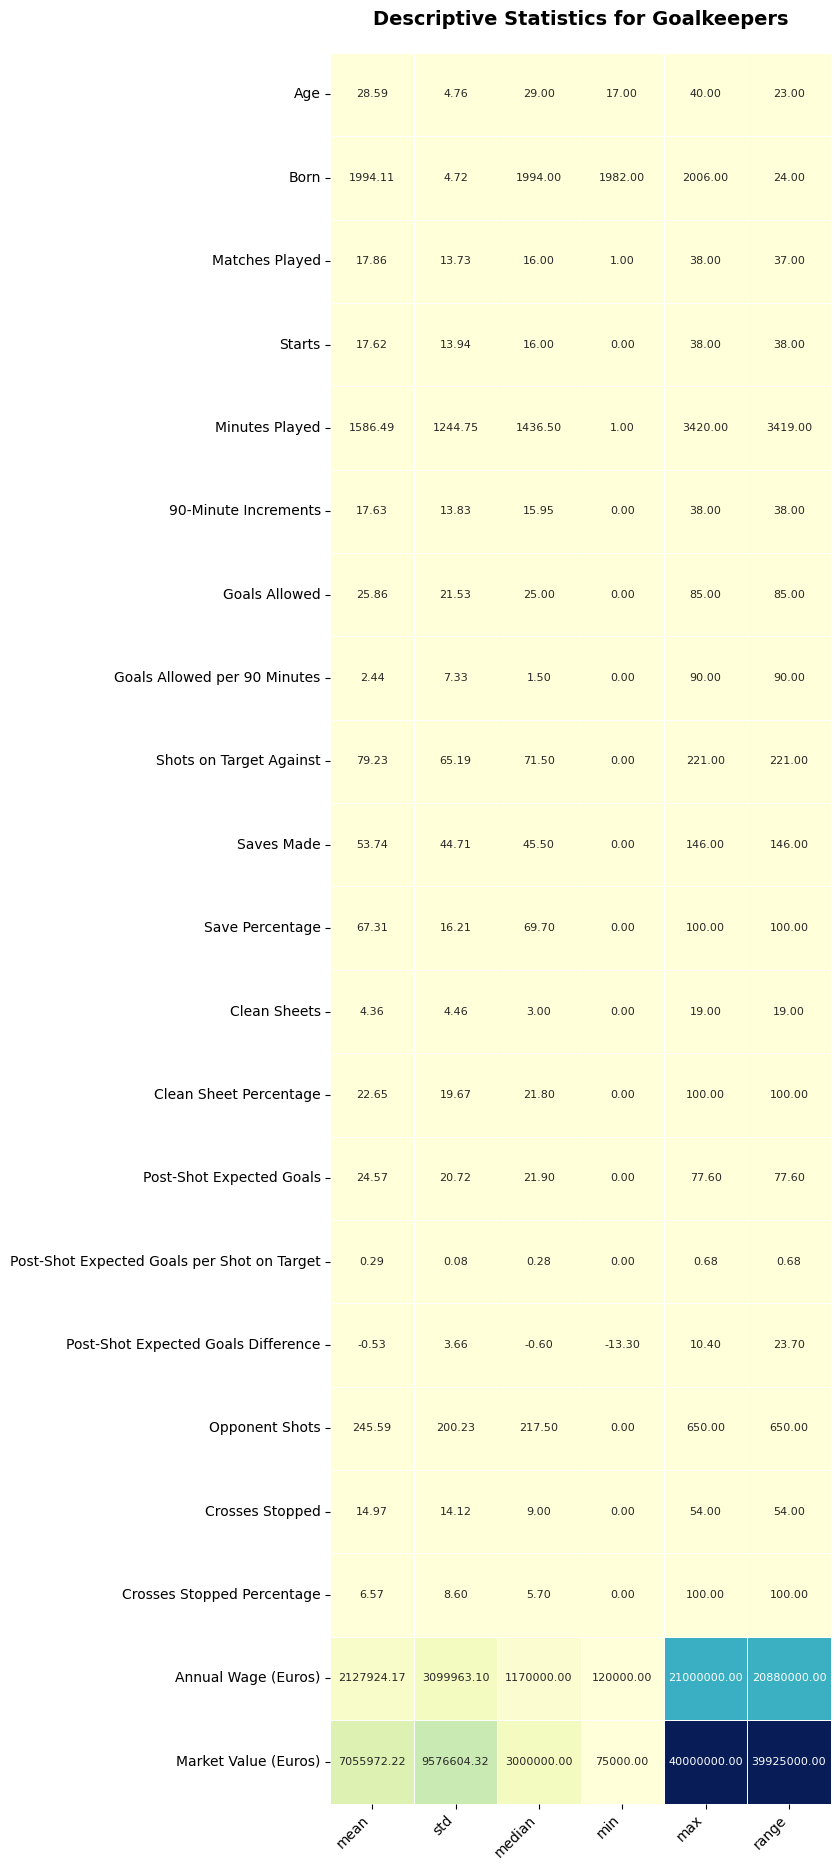

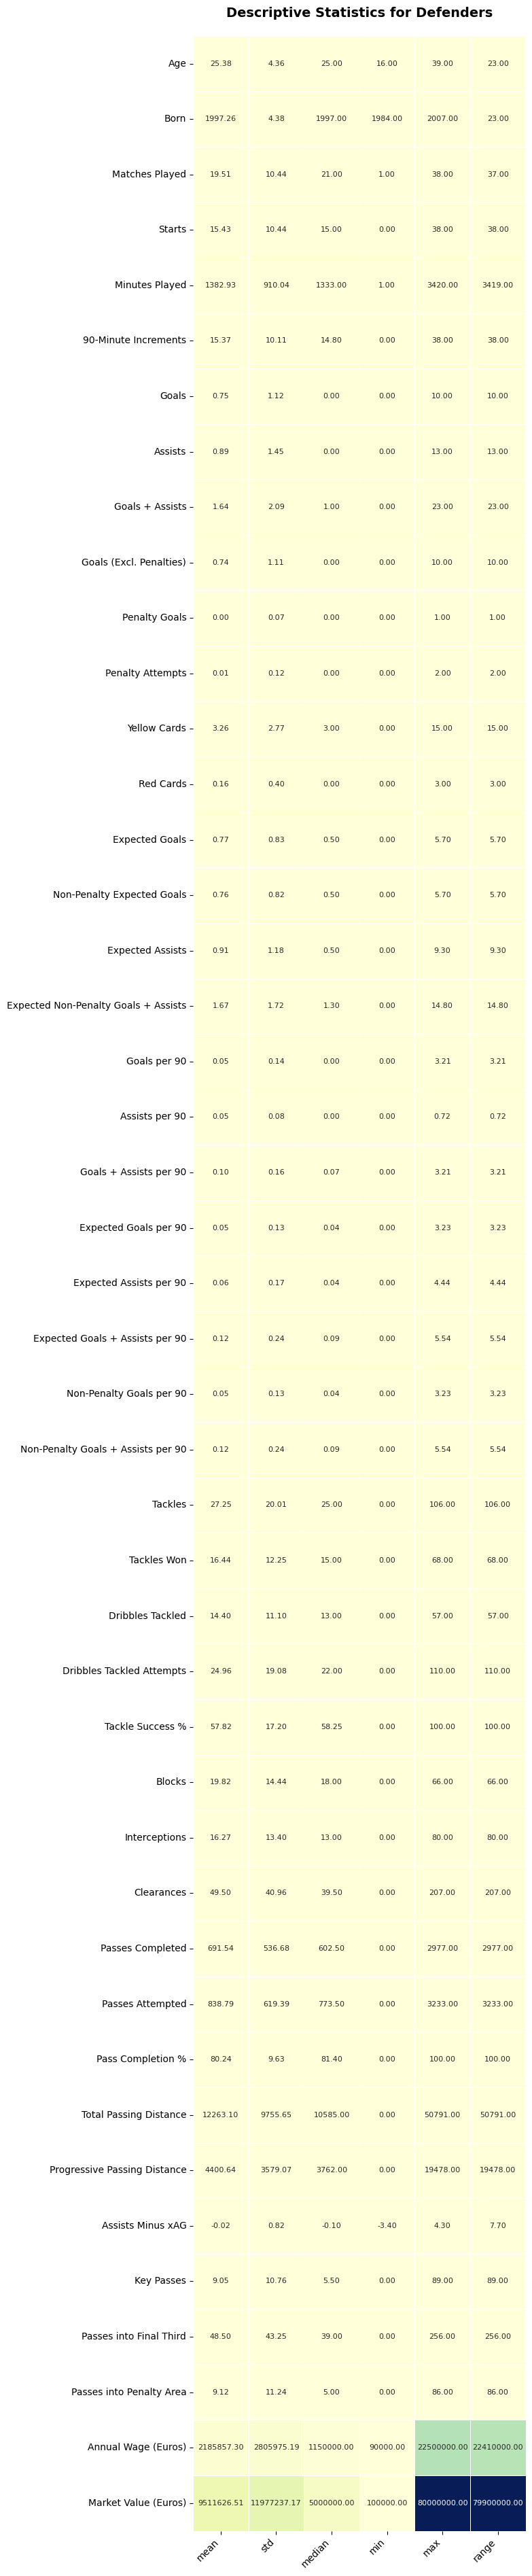

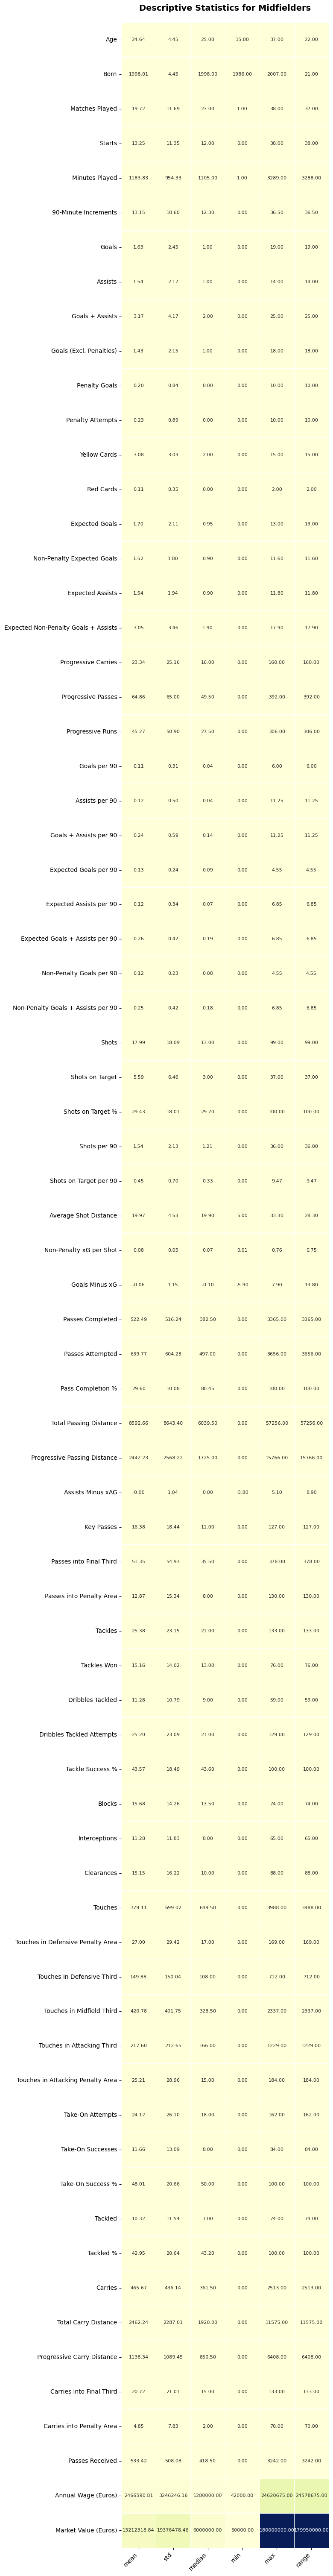

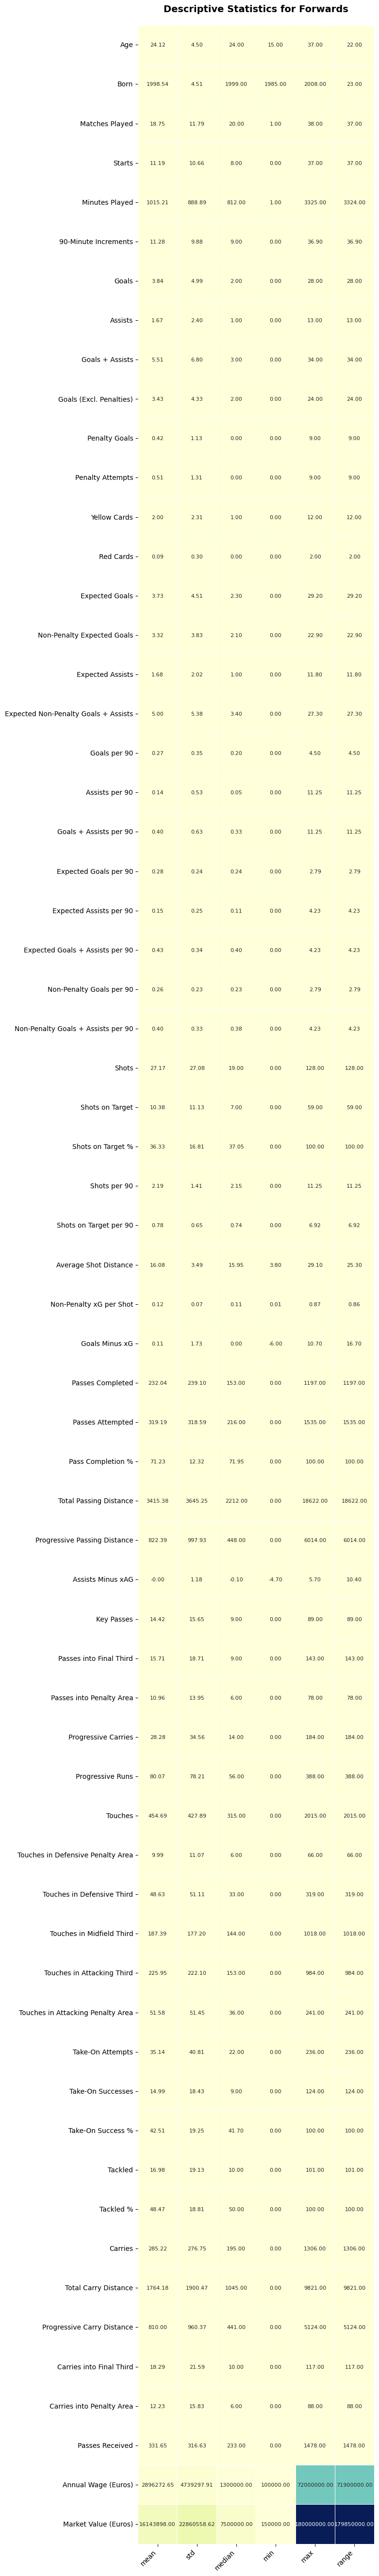

In [6]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.8 + 2))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 6: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


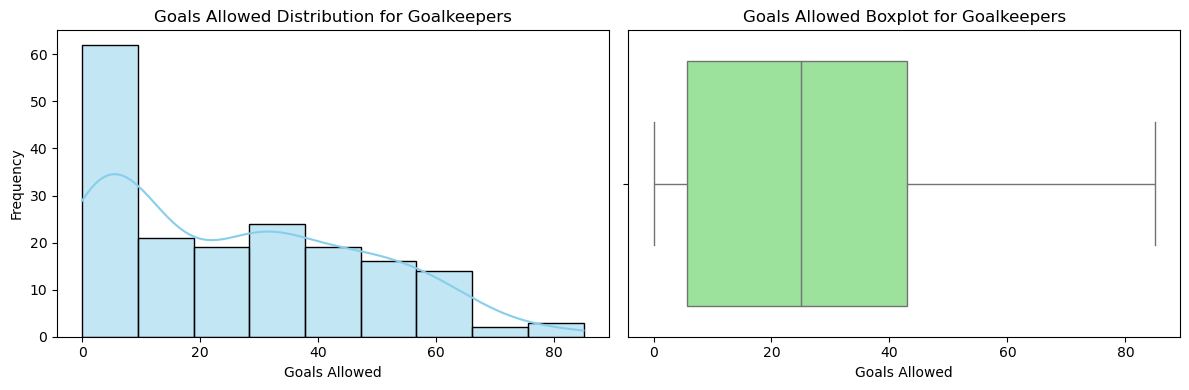

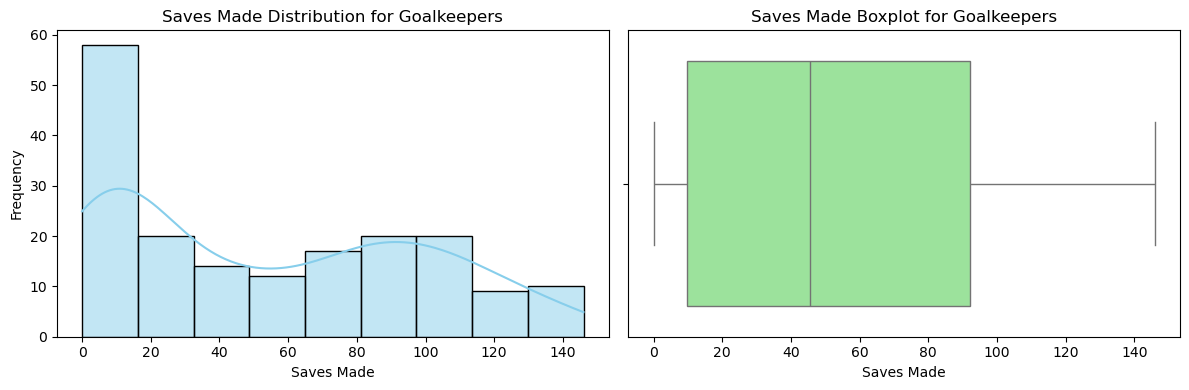

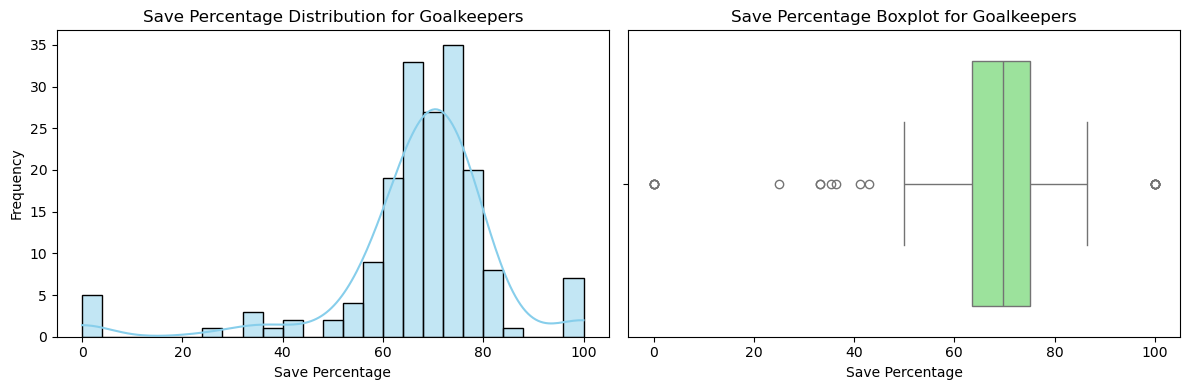

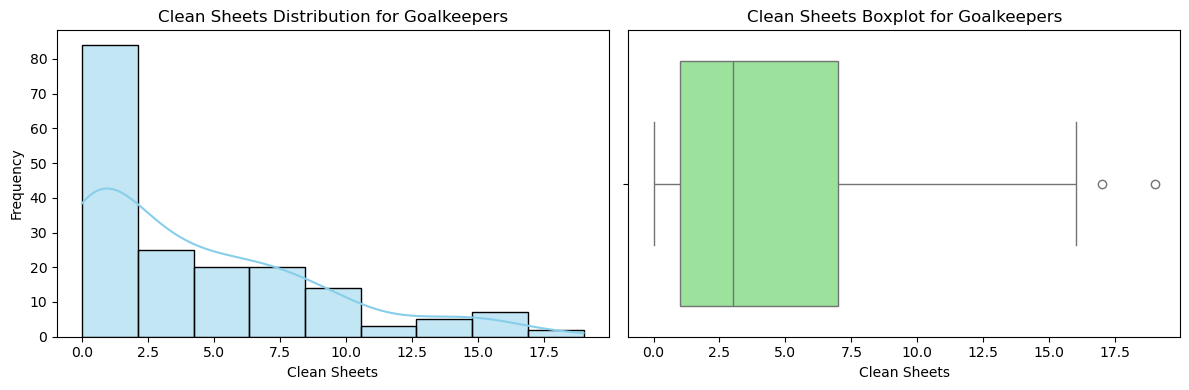

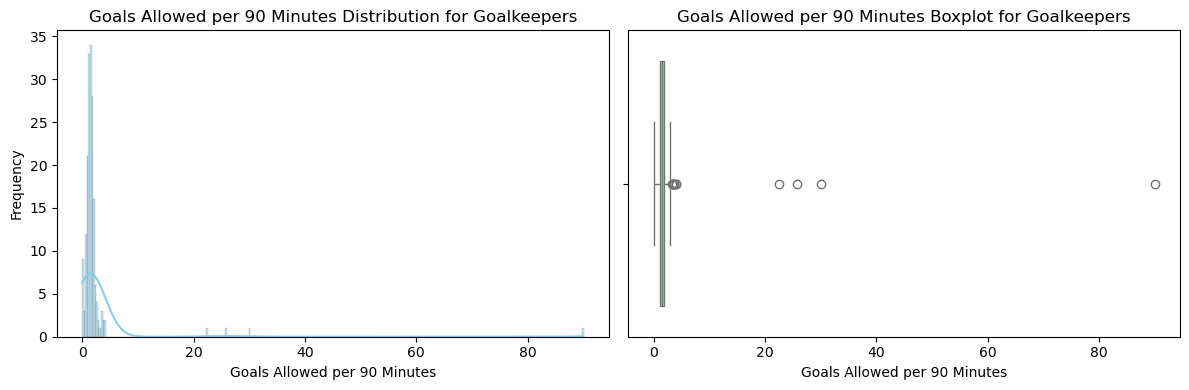

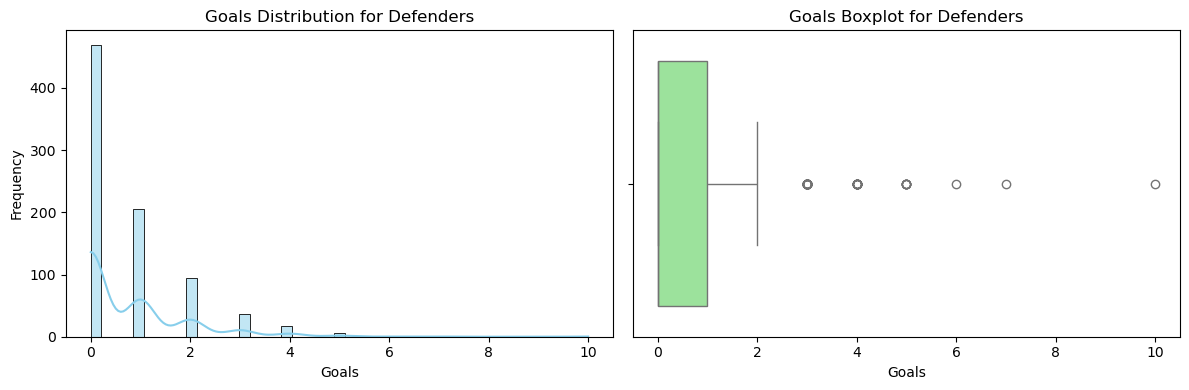

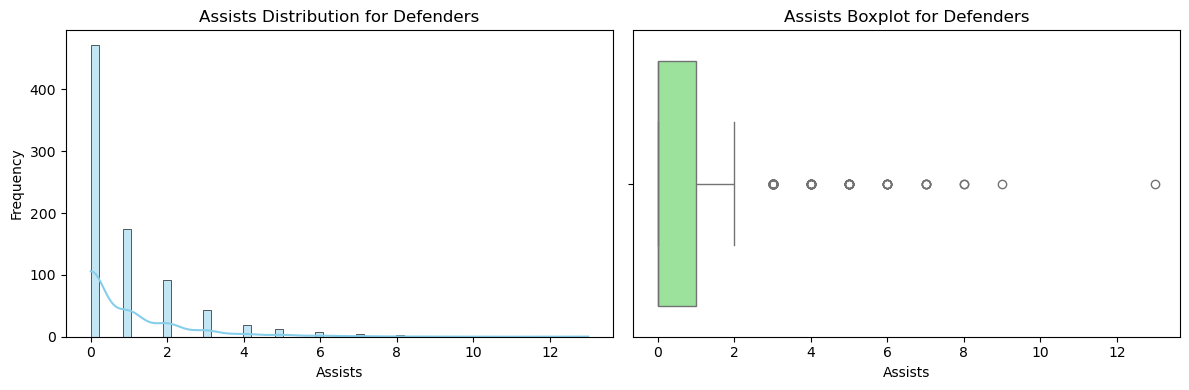

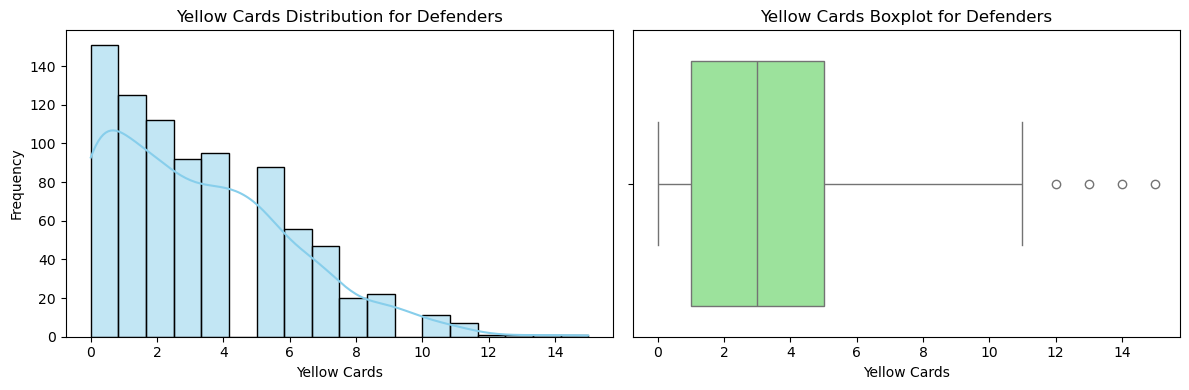

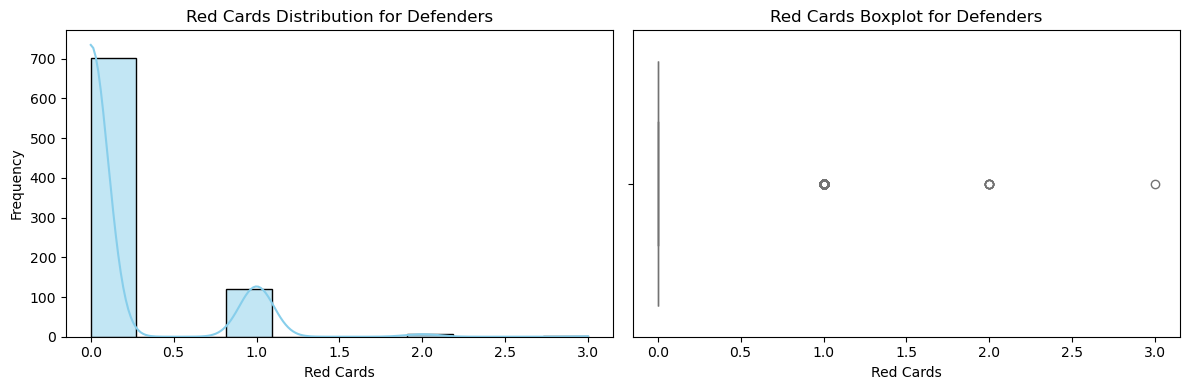

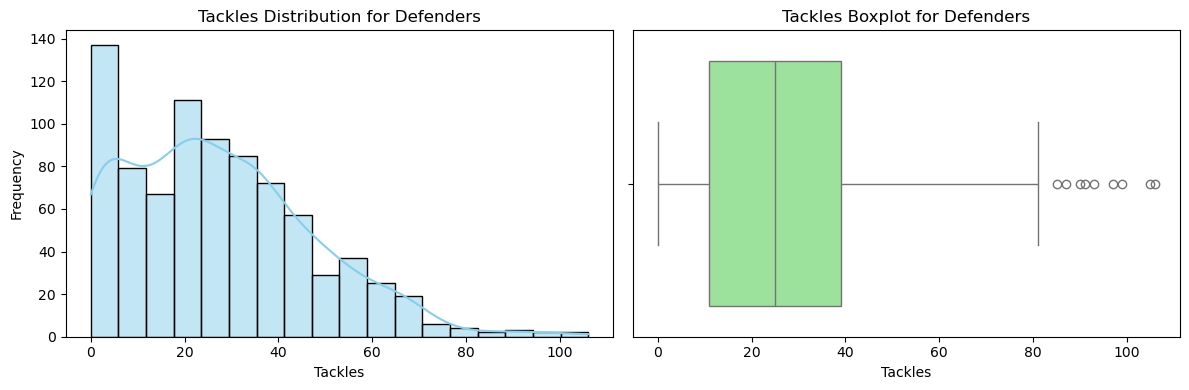

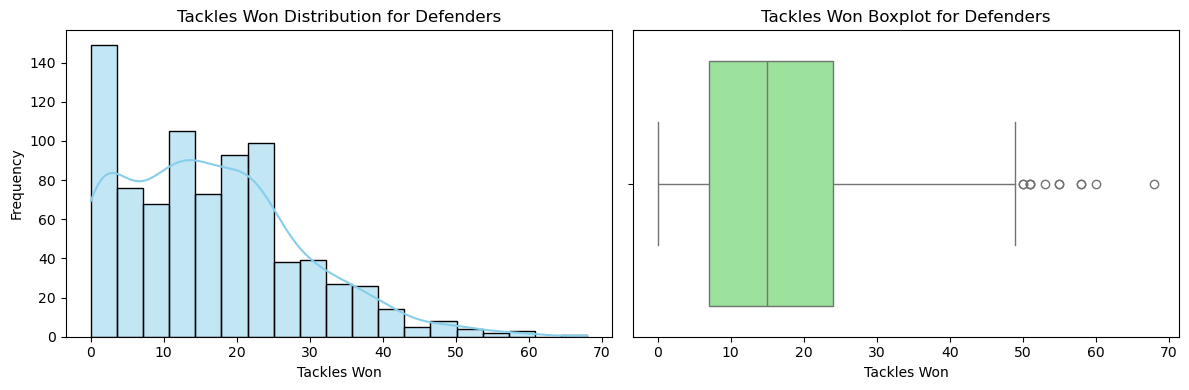

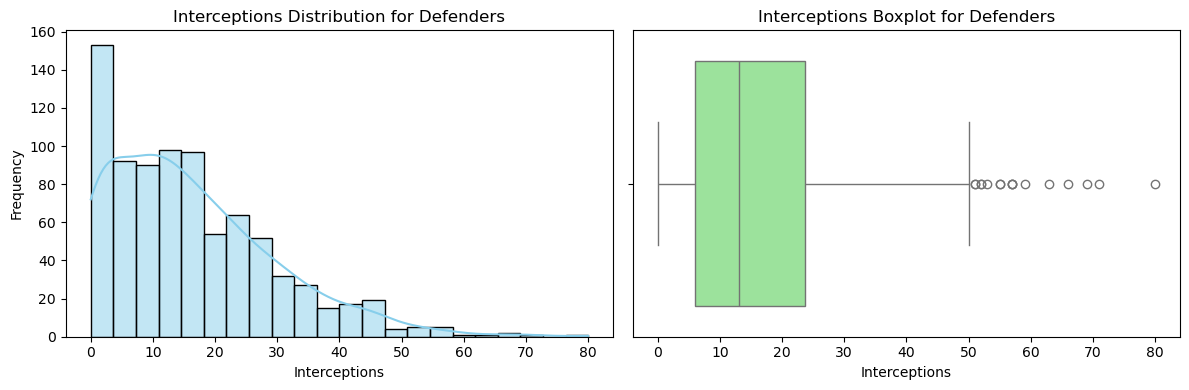

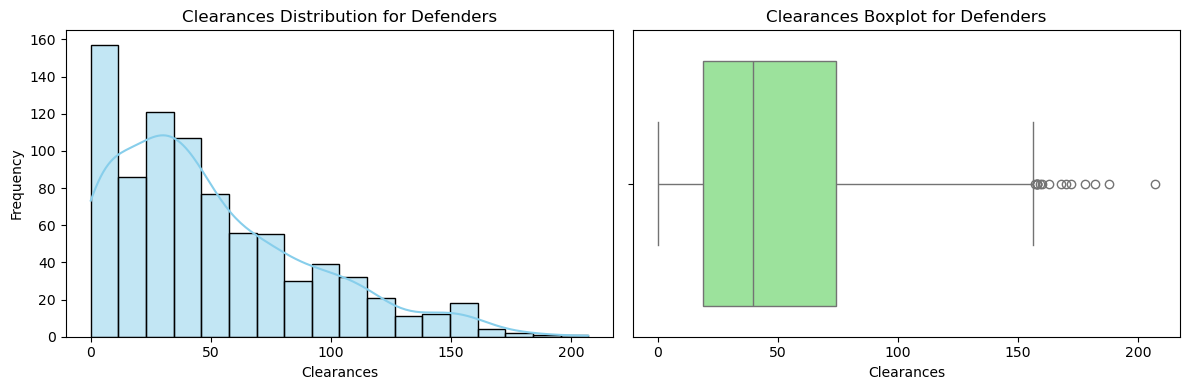

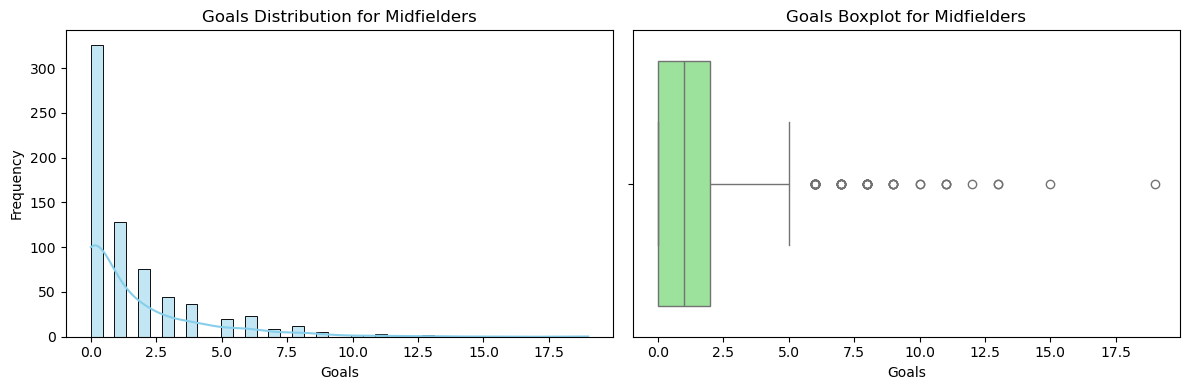

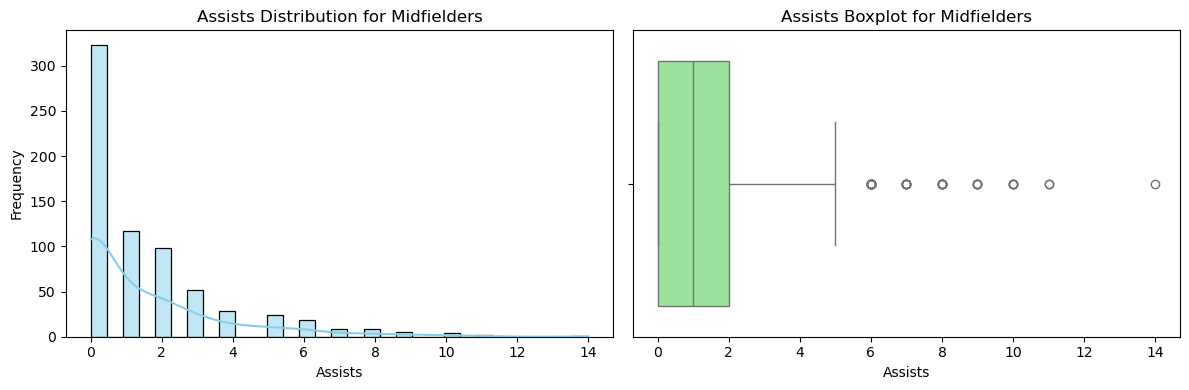

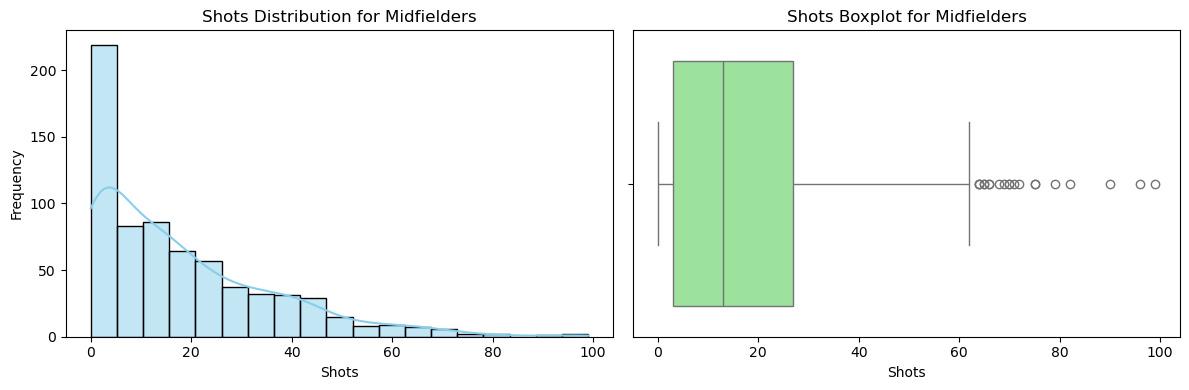

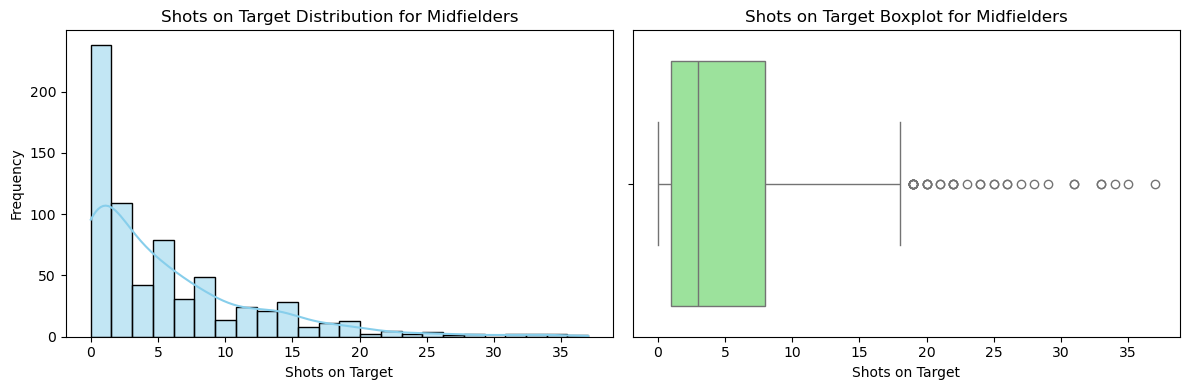

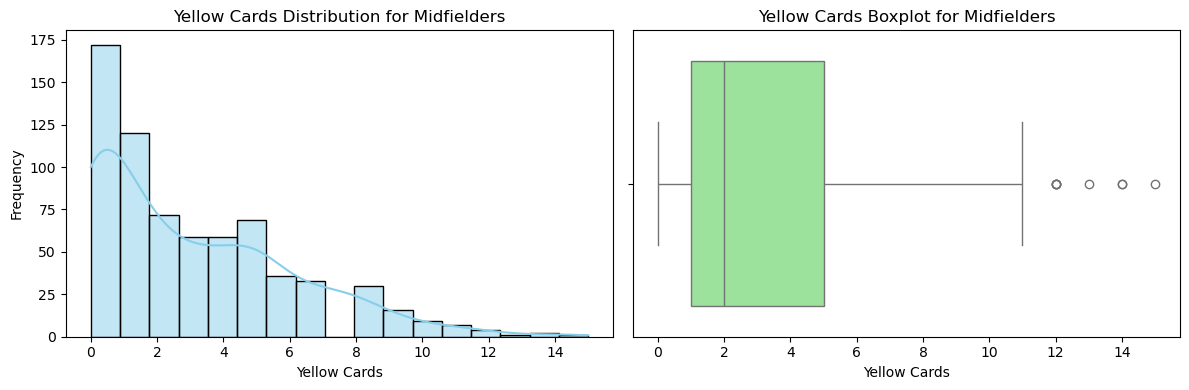

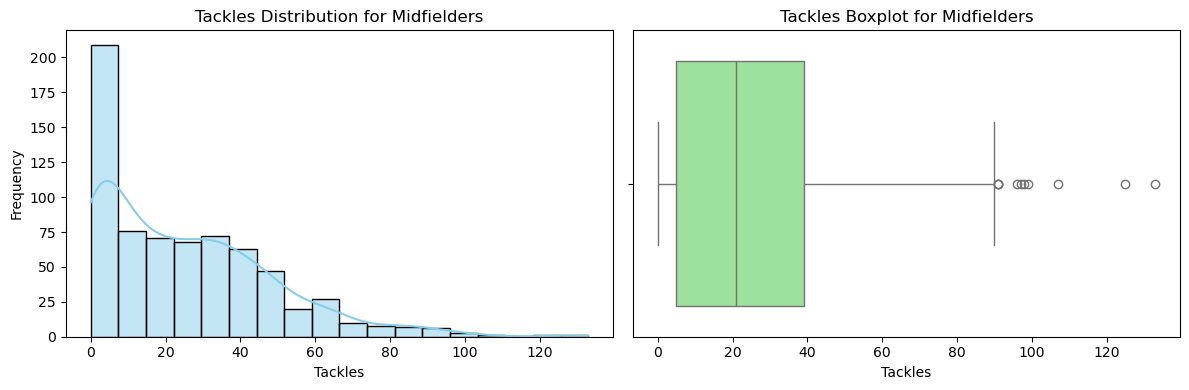

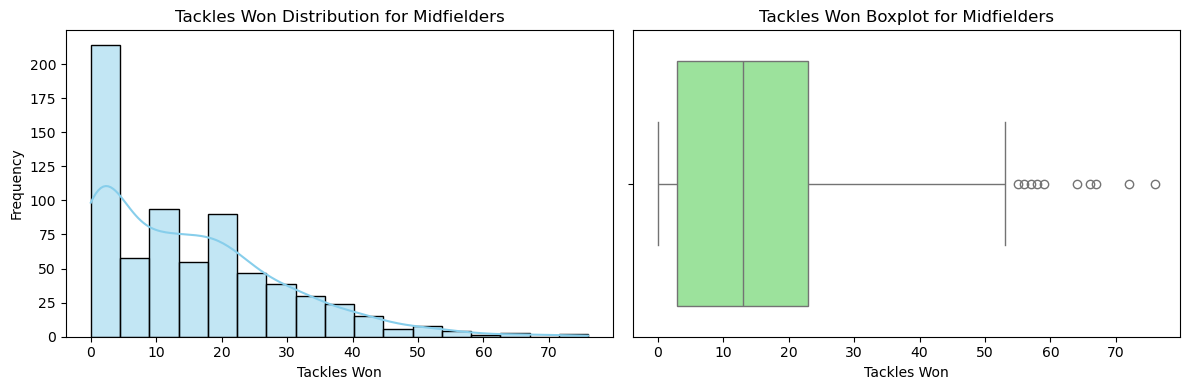

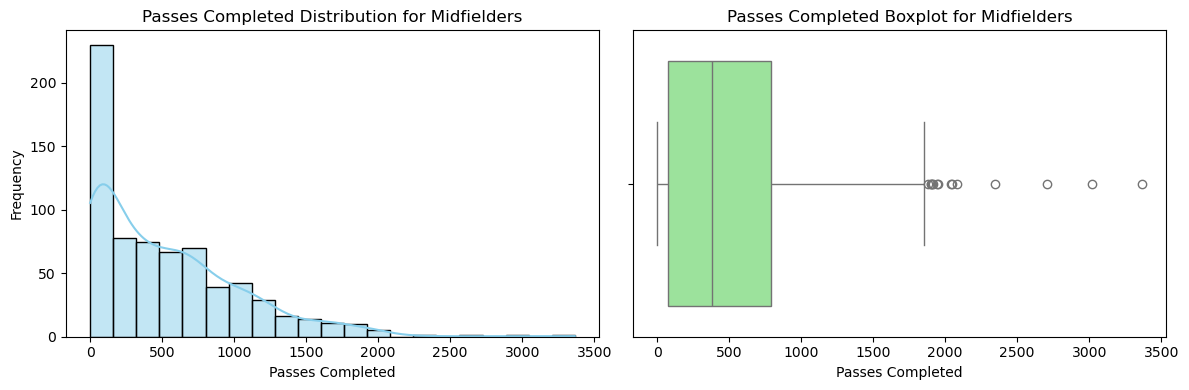

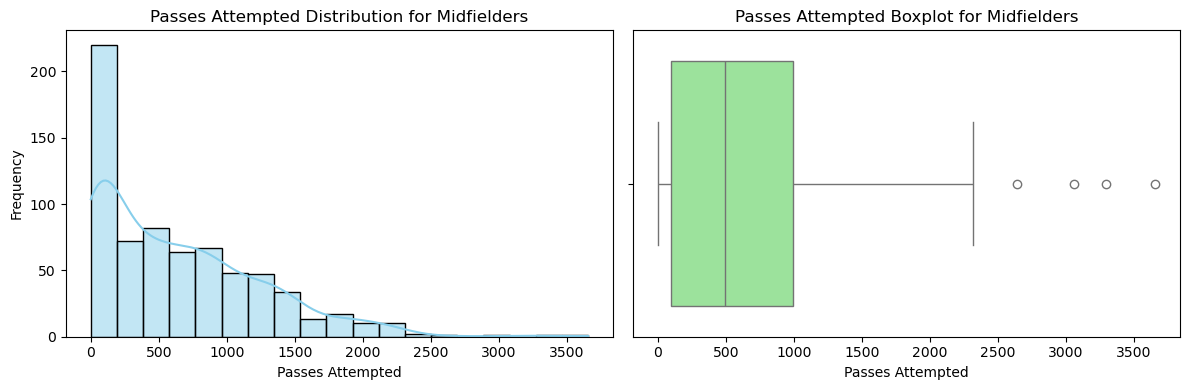

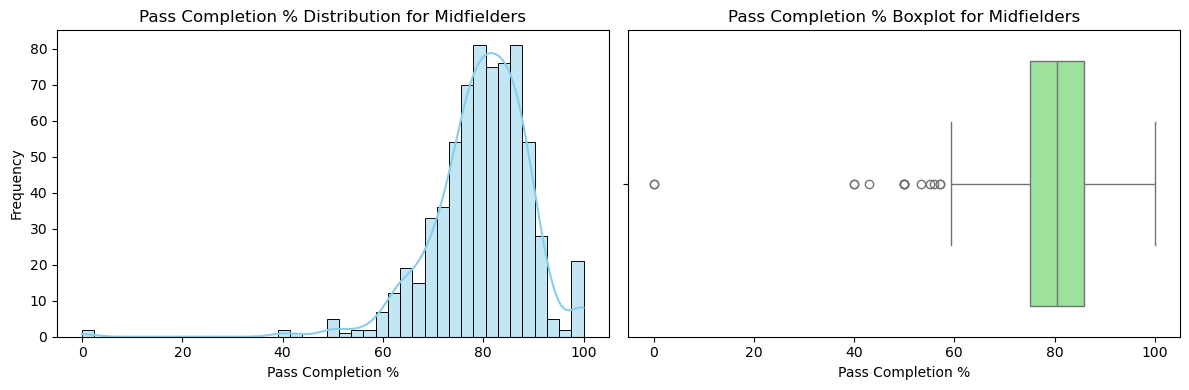

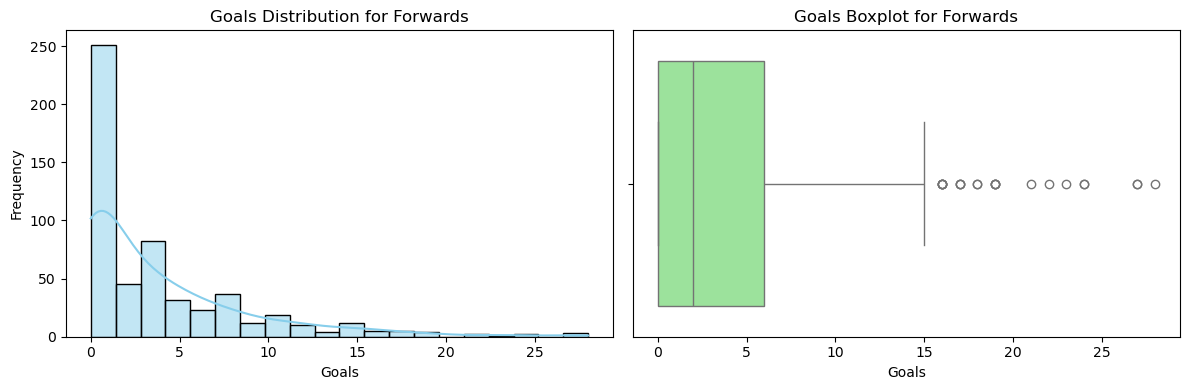

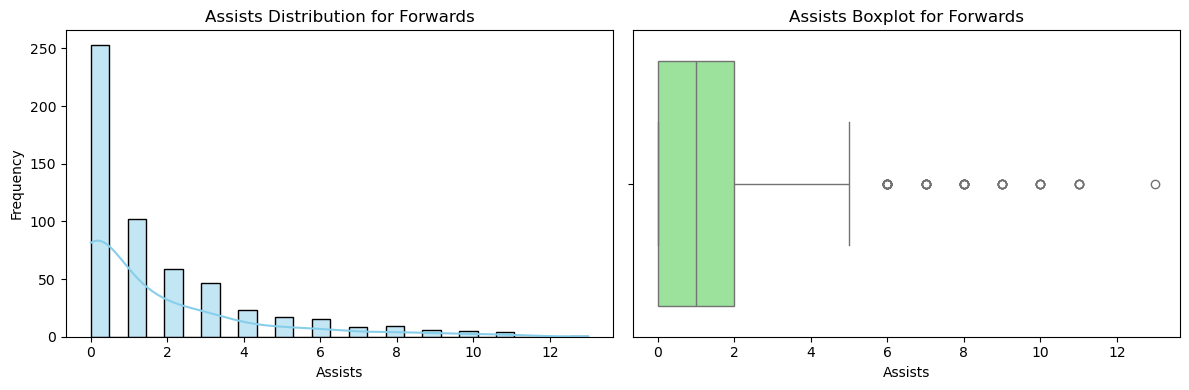

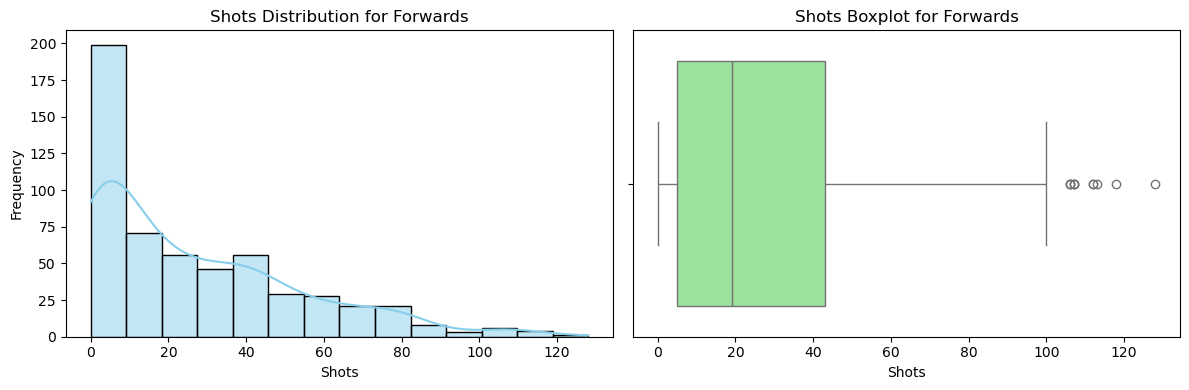

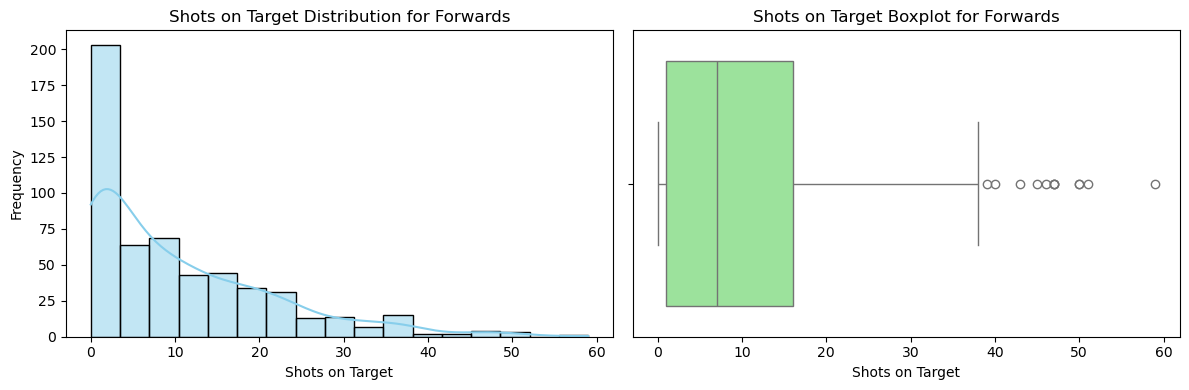

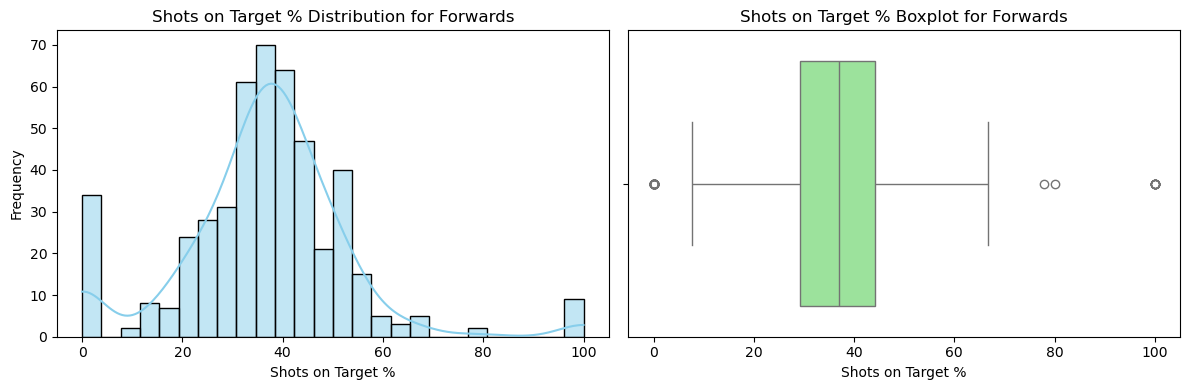

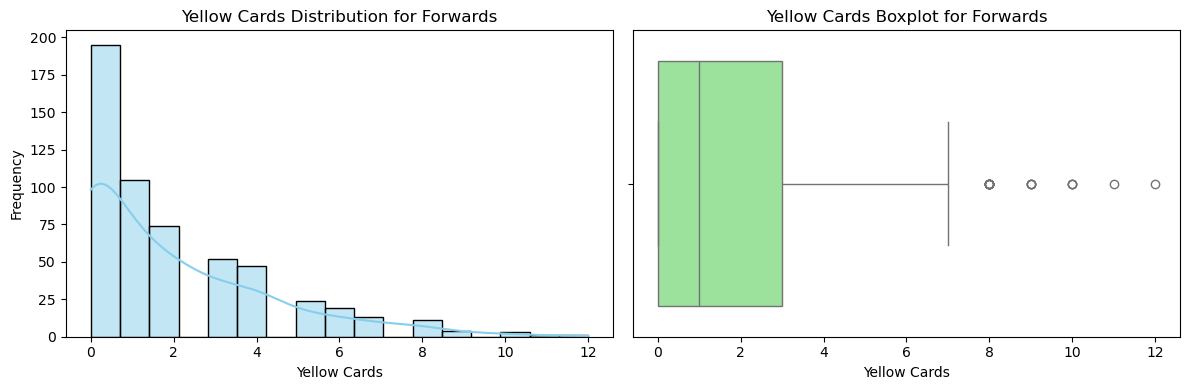

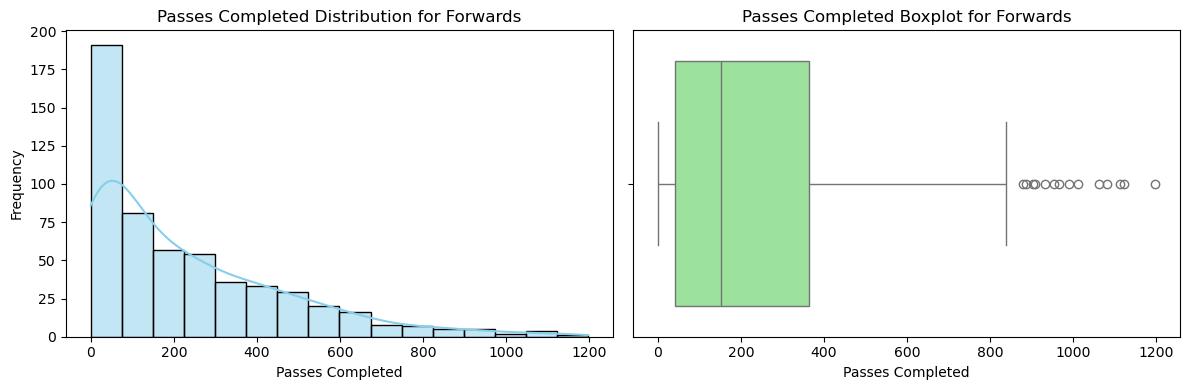

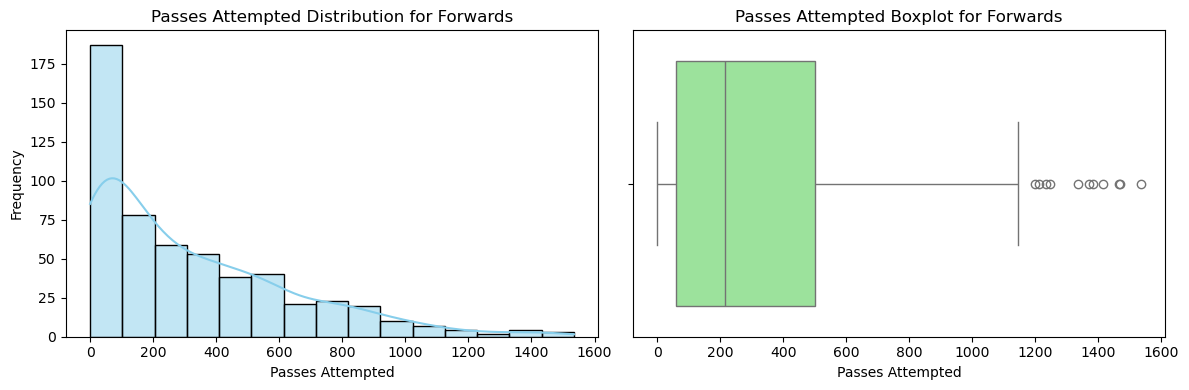

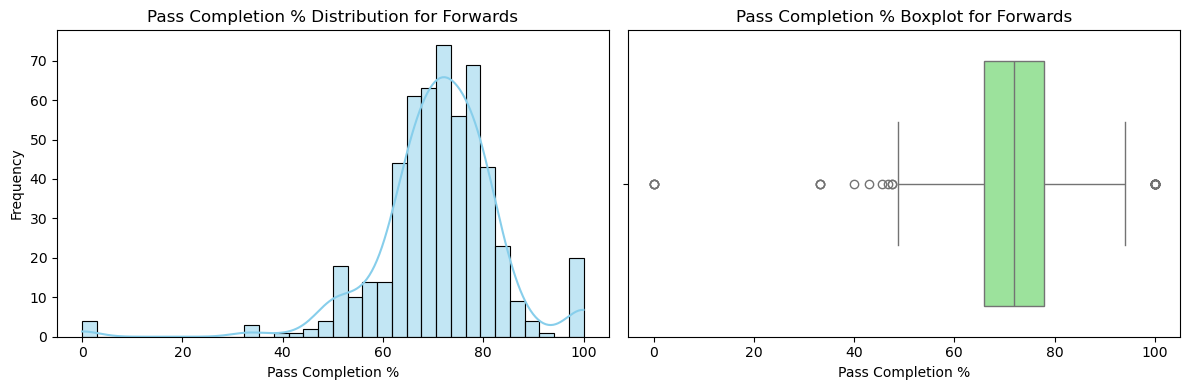

In [7]:

basic_stats = {
    'Goalkeepers': ['Goals Allowed', 'Saves Made', 'Save Percentage', 'Clean Sheets', 'Goals Allowed per 90 Minutes'],
    'Defenders': ['Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'Tackles', 'Tackles Won', 'Interceptions', 'Clearances'],
    'Midfielders': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Yellow Cards', 'Tackles', 'Tackles Won', 'Passes Completed', 'Passes Attempted', 'Pass Completion %'],
    'Forwards': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Shots on Target %', 'Yellow Cards', 'Passes Completed', 'Passes Attempted', 'Pass Completion %']
}

def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()


for position, df in dataframes.items():
    plot_and_save_plots(df, position, basic_stats[position])


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 7: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


Generating correlation heatmap for Goalkeepers...


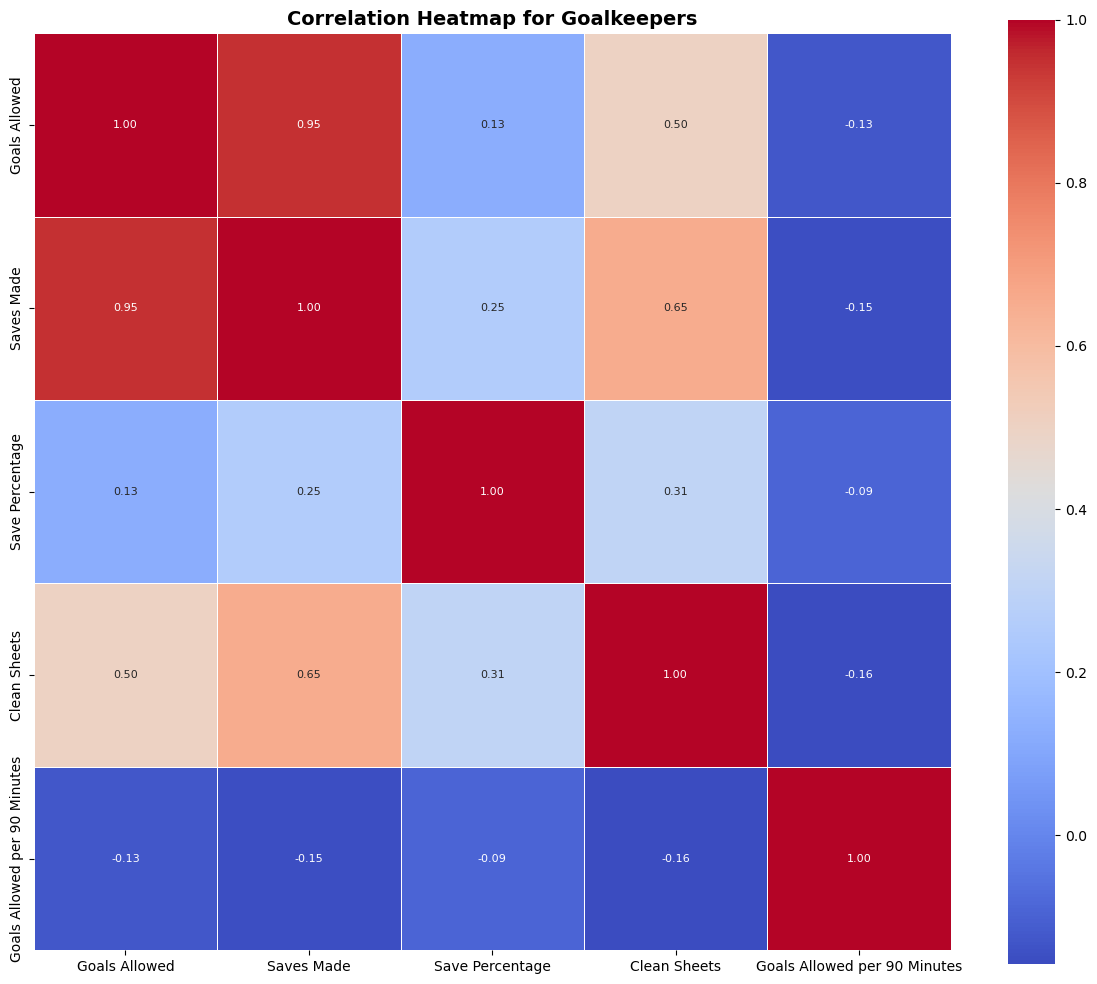

Generating correlation heatmap for Defenders...


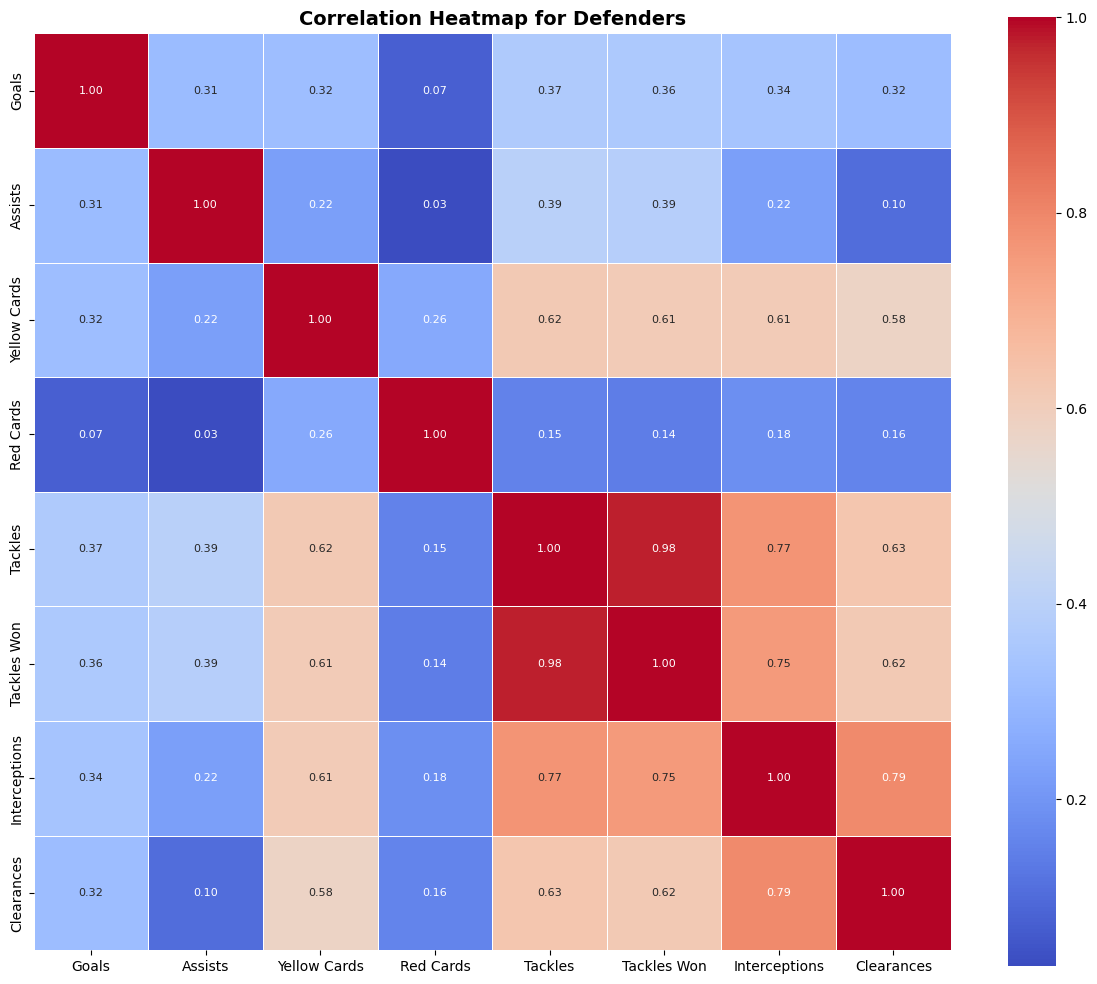

Generating correlation heatmap for Midfielders...


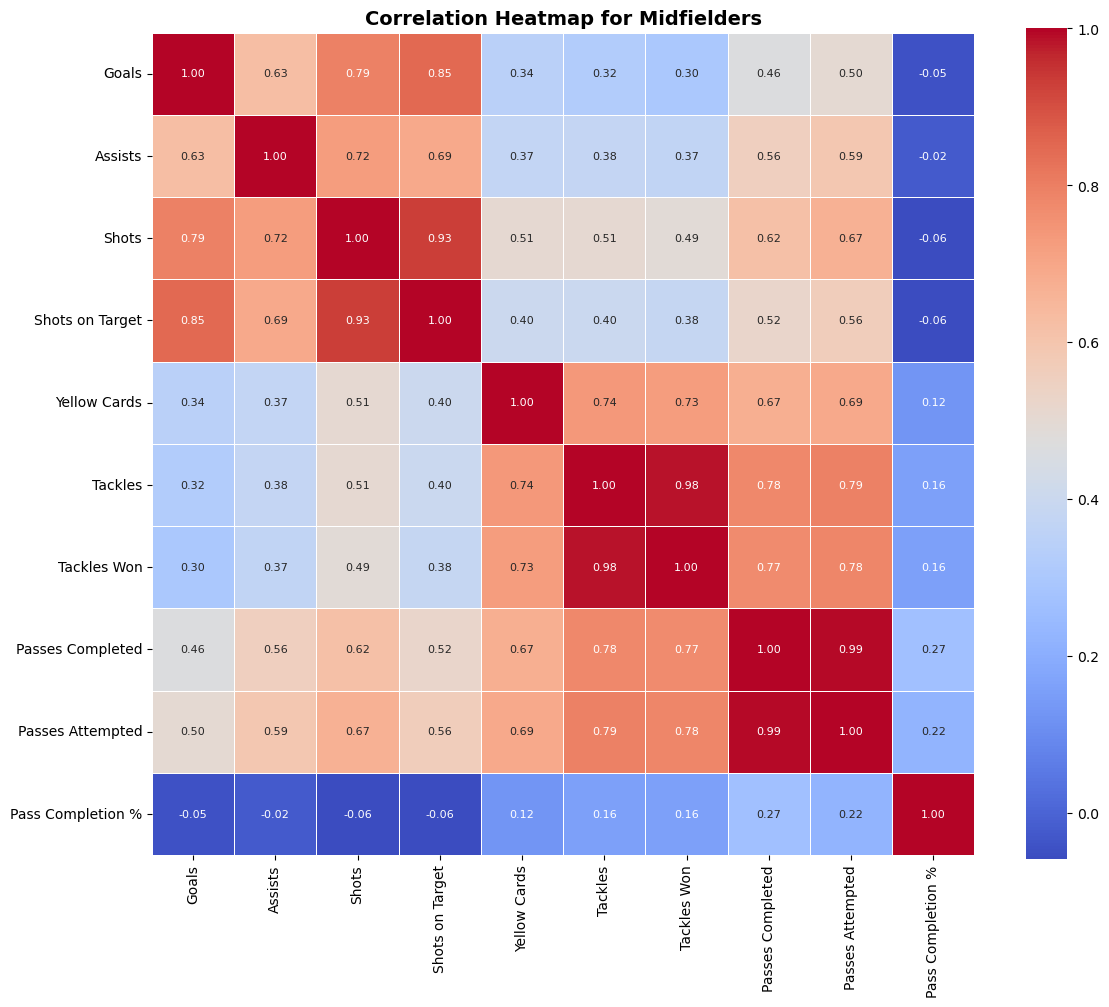

Generating correlation heatmap for Forwards...


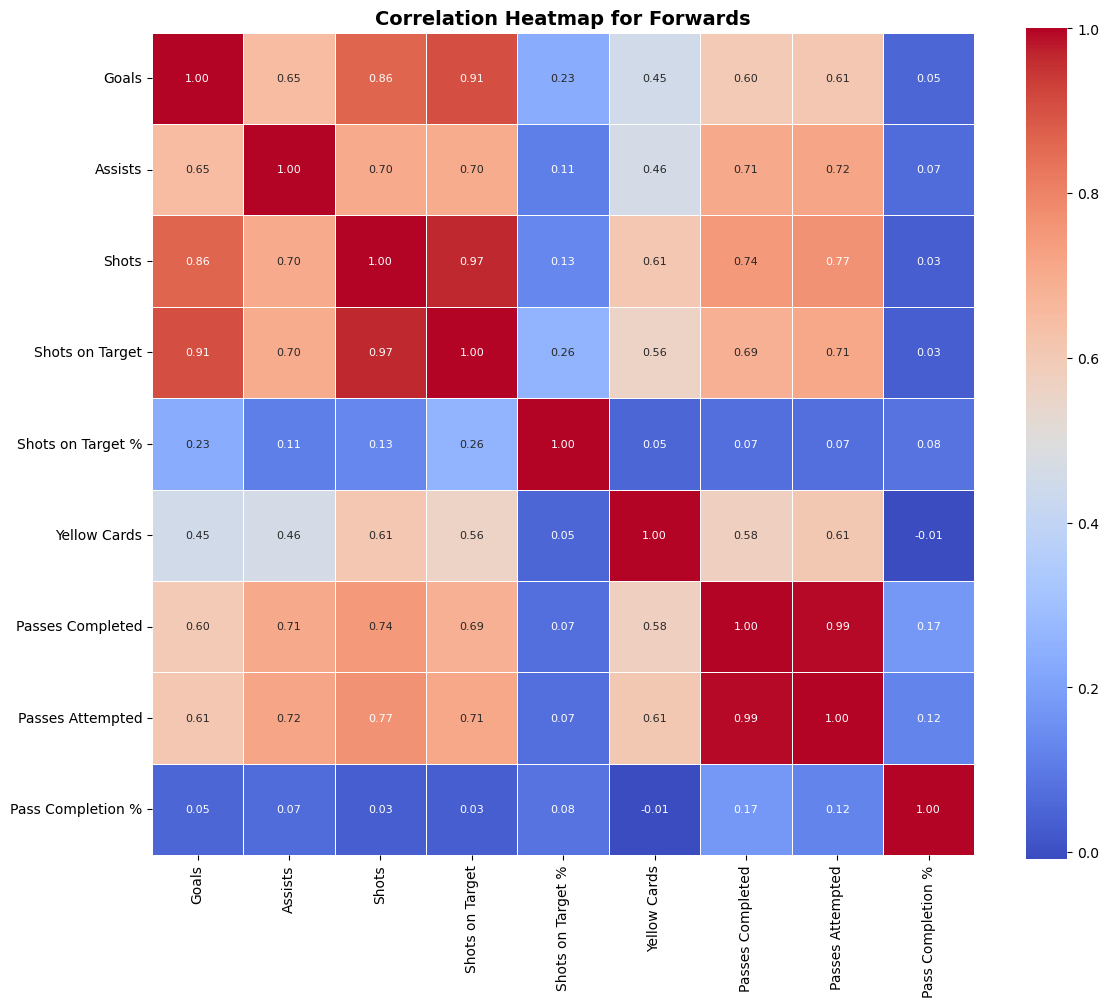

In [8]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    save_correlation_heatmap(df, position, basic_stats[position])


<a id="PCA"></a>

## <div class='section'>Section 8: Principal Component Analysis</div>

[Return to contents](#contents)

<a id="defense-pca"></a>

### <div class='subsection'>8.1 Defense PCA</div>

In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 45.
The number of components required to explain 95% of the variance is: 16.


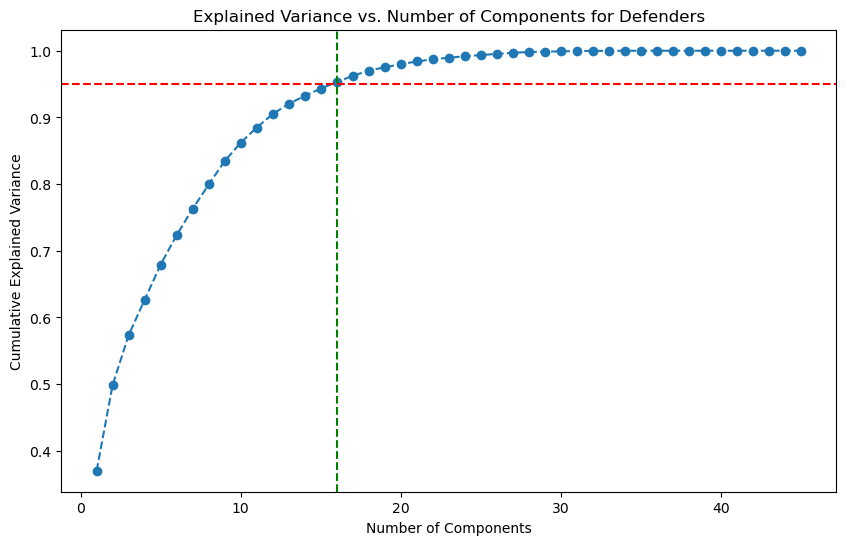

In [9]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

defender_train, defender_test = train_test_split(defenders, test_size=0.2, random_state=42)

defender_numeric_train = defender_train.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()
defender_numeric_test = defender_test.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()


defender_train = defender_train.loc[defender_numeric_train.index].reset_index(drop=True)
defender_test = defender_test.loc[defender_numeric_test.index].reset_index(drop=True)


defender_y_train = np.log1p(defender_train['Market Value (Euros)'])
defender_y_test = np.log1p(defender_test['Market Value (Euros)'])

pca = PCA()
defender_pca= pca.fit_transform(defender_numeric_train)
defender_pca1= pca.transform(defender_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

defender_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {defender_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=defender_valid_components, color='g', linestyle='--', label=f'{defender_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()

In order to explain 95% of the variancee, only 16 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [10]:
defender_train['PC1'] = defender_pca[:, 0]
defender_train['PC2'] = defender_pca[:, 1]

defender_test['PC1'] = defender_pca1[:, 0]
defender_test['PC2'] = defender_pca1[:, 1]

top_defenders = defender_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])

Top 10 defenders based on PC1:
                     Player     PC1
355           Álex Grimaldo  16.541
289             Pedro Porro  13.741
221     Giovanni Di Lorenzo  11.814
757        Jeremie Frimpong  11.130
260        Antonee Robinson  10.335
413              David Raum  10.247
454  Trent Alexander-Arnold  10.067
112         Kieran Trippier  10.014
335           Alfie Doughty   9.737
618         Cristian Romero   9.661


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. These players also tend to be higher-performing.

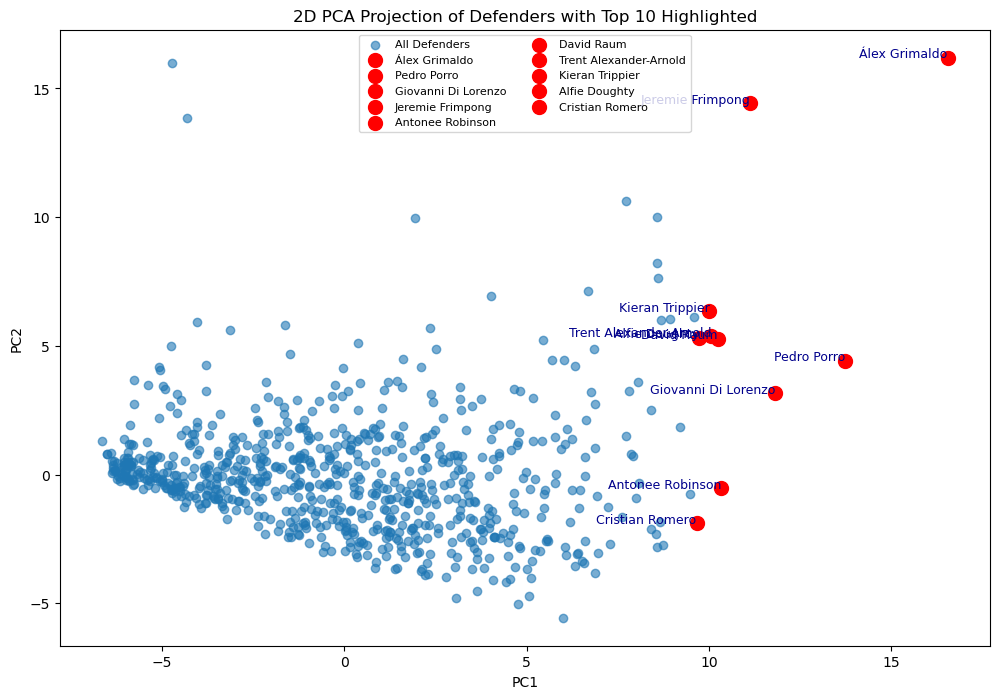

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(defender_pca[:, 0], defender_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered and spread outwards. It is also apparent that there are no distinct groups outside of the large mass. However, the "top" defenders are at the edges of the cluster due to their high PC1 values. It is interesting to investigate why our higher performing athletes tend to be on the outskirts of the PCA. 

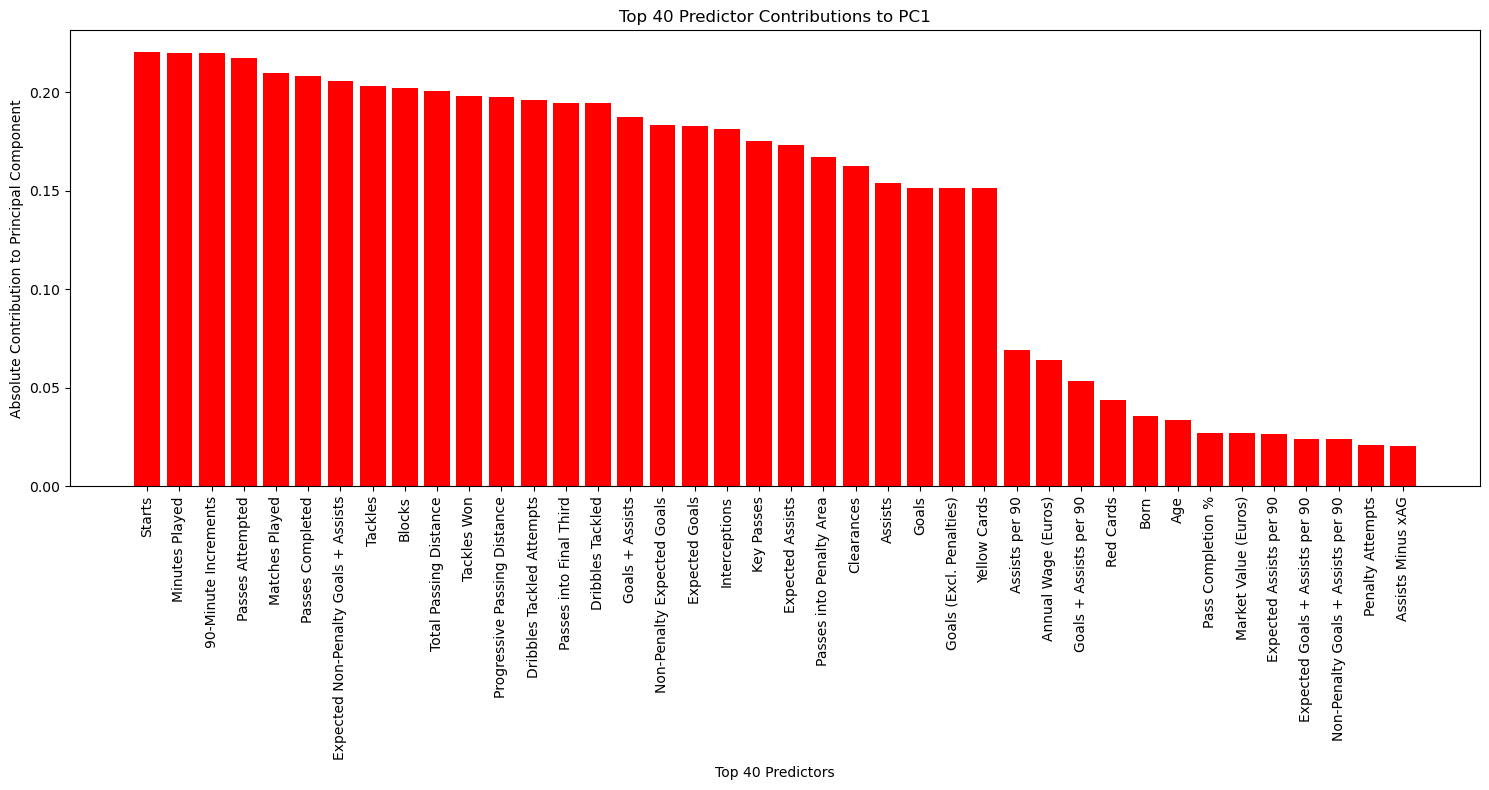

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features to our first principal components. This gives us an idea of what features contribute most to the variance within athletes.

<a id="midfielder-pca"></a>

### <div class='subsection'>8.2 Midfielder PCA</div>

In this section we split the midfielder data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 73.
The number of components required to explain 95% of the variance is: 20.


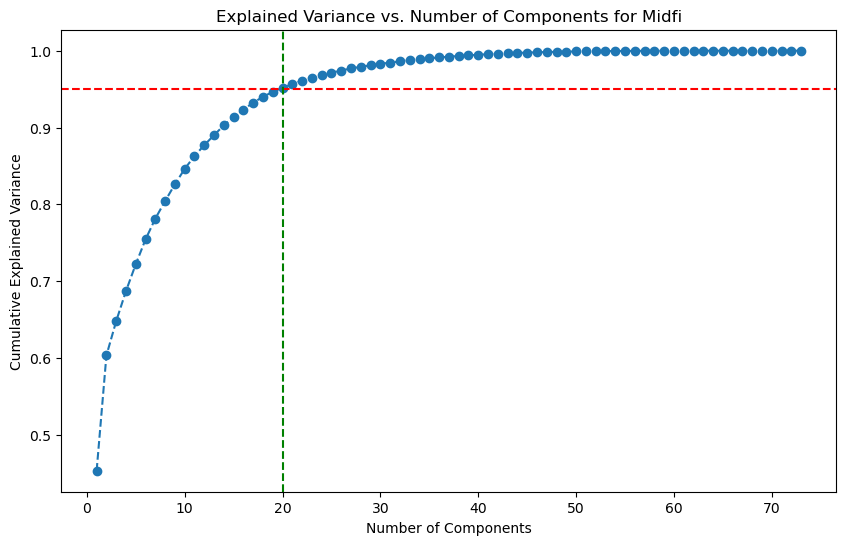

In [13]:
midfielders_train, midfielders_test = train_test_split(midfielders, test_size=0.2, random_state=42)

midfielders_numeric_train = midfielders_train.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()
midfielders_numeric_test = midfielders_test.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()


midfielders_train = midfielders_train.loc[midfielders_numeric_train.index].reset_index(drop=True)
midfielders_test = midfielders_test.loc[midfielders_numeric_test.index].reset_index(drop=True)


midfielders_y_train = np.log1p(midfielders_train['Market Value (Euros)'])
midfielders_y_test = np.log1p(midfielders_test['Market Value (Euros)'])

pca = PCA()
midfielders_pca= pca.fit_transform(midfielders_numeric_train)
midfielders_pca1= pca.transform(midfielders_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

midfielders_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {midfielders_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=midfielders_valid_components, color='g', linestyle='--', label=f'{midfielders_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfi')
plt.show()

In order to explain 95% of the variancee, only 20 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [14]:
midfielders_train['PC1'] = midfielders_pca[:, 0]
midfielders_train['PC2'] = midfielders_pca[:, 1]

midfielders_test['PC1'] = midfielders_pca1[:, 0]
midfielders_test['PC2'] = midfielders_pca1[:, 1]

top_midfielders = midfielders_train.nlargest(10, 'PC1')

print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])

Top 10 midfielders based on PC1:
              Player     PC1
132            Rodri  19.196
106  Bruno Fernandes  17.994
555      Pascal Groß  17.685
242    Florian Wirtz  16.489
524  Martin Ødegaard  16.345
63   Bruno Guimarães  16.160
197      Xavi Simons  15.088
554      Declan Rice  14.273
390   İlkay Gündoğan  14.021
439     Kevin Stöger  13.825


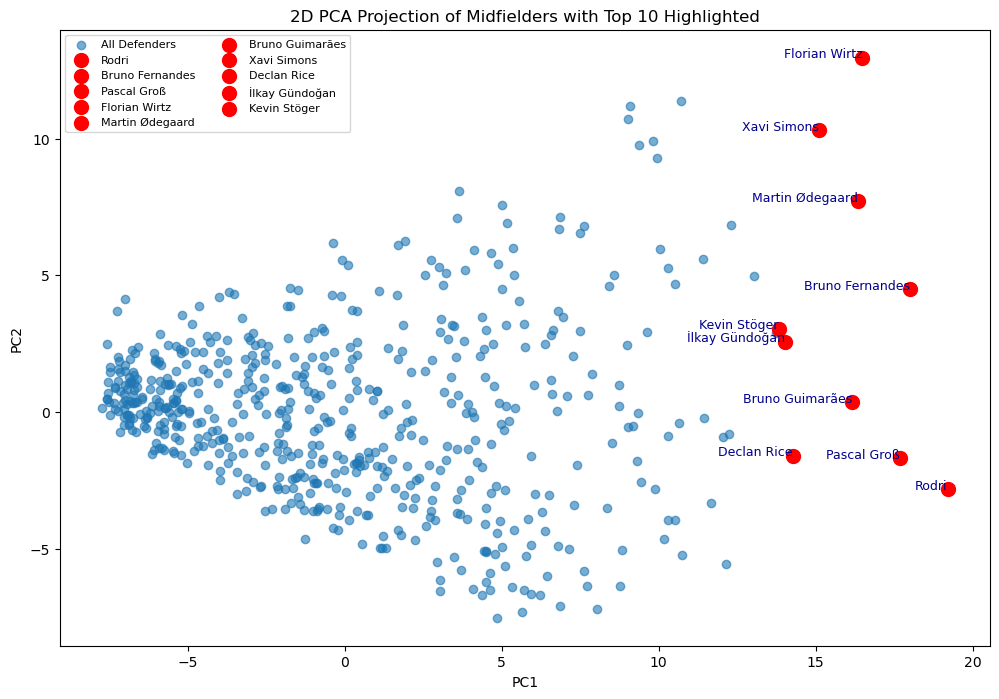

In [15]:
# graphing PCA with names
plt.figure(figsize=(12, 8))
plt.scatter(midfielders_pca[:, 0], midfielders_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Midfielders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

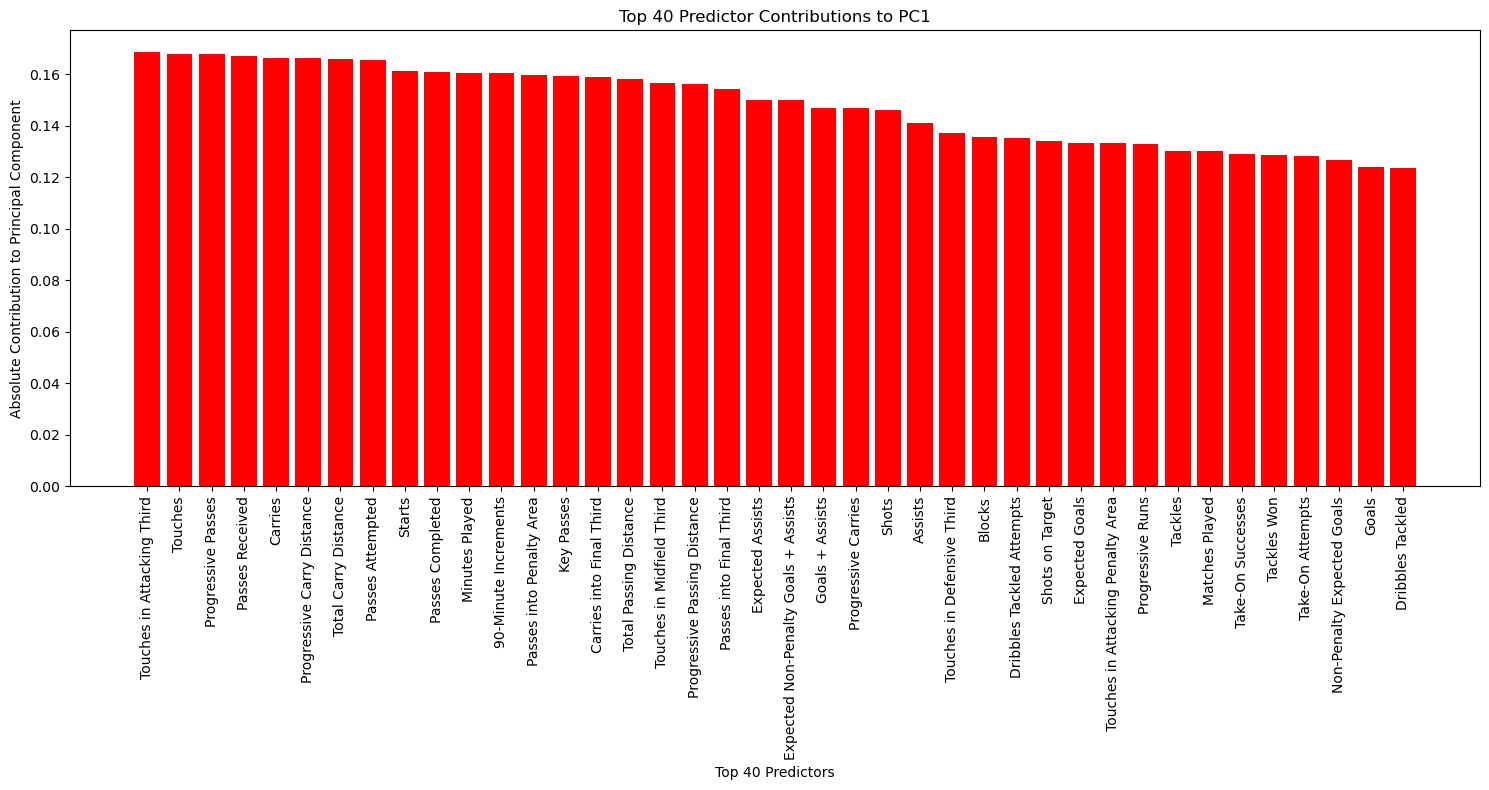

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = midfielders_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="goalkeeper-pca"></a>

### <div class='subsection'>8.3 Goalkeeper PCA</div>

In this section we split the goalkeeper data into training and testing data and do a PCA analysis on the training data.

[Return to Section 8](#PCA)

The total number of components is: 21.
The number of components required to explain 95% of the variance is: 8.


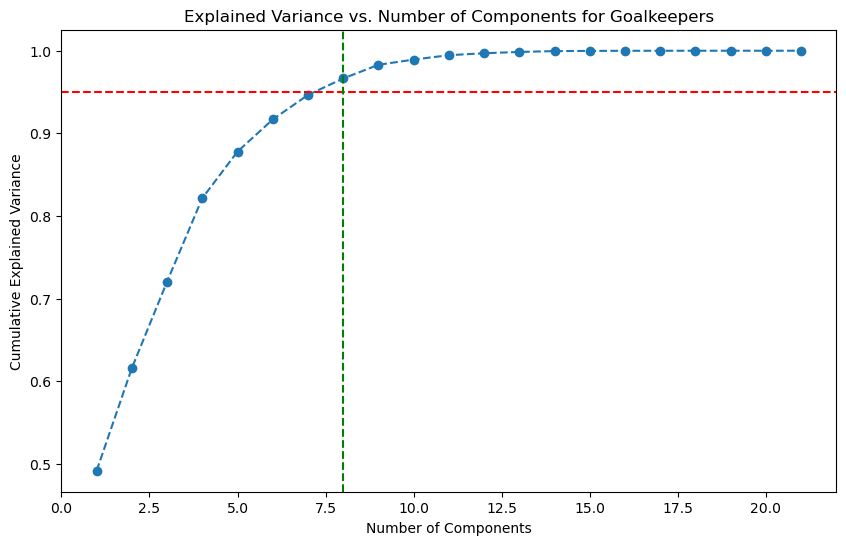

In [17]:
from sklearn.decomposition import PCA

goalkeepers_train, goalkeepers_test = train_test_split(goalkeepers, test_size=0.2, random_state=42)

goalkeepers_numeric_train = goalkeepers_train.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()
goalkeepers_numeric_test = goalkeepers_test.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()


goalkeepers_train = goalkeepers_train.loc[goalkeepers_numeric_train.index].reset_index(drop=True)
goalkeepers_test = goalkeepers_test.loc[goalkeepers_numeric_test.index].reset_index(drop=True)


goalkeepers_y_train = np.log1p(goalkeepers_train['Market Value (Euros)'])
goalkeepers_y_test = np.log1p(goalkeepers_test['Market Value (Euros)'])

pca = PCA()
goalkeepers_pca= pca.fit_transform(goalkeepers_numeric_train)
goalkeepers_pca1= pca.transform(goalkeepers_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

goalkeepers_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {goalkeepers_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=goalkeepers_valid_components, color='g', linestyle='--', label=f'{goalkeepers_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.show()

In order to explain 95% of the variancee, only 8 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [18]:
goalkeepers_train['PC1'] = goalkeepers_pca[:, 0]
goalkeepers_train['PC2'] = goalkeepers_pca[:, 1]

goalkeepers_test['PC1'] = goalkeepers_pca1[:, 0]
goalkeepers_test['PC2'] = goalkeepers_pca1[:, 1]

top_goalkeepers= goalkeepers_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_goalkeepers[['Player', 'PC1']])

Top 10 defenders based on PC1:
                Player    PC1
119    Filip Jørgensen  5.066
118    Thomas Kaminski  4.891
88     Jordan Pickford  4.863
9      Paulo Gazzaniga  4.797
60          Bernd Leno  4.649
114  Guglielmo Vicario  4.588
27      Oliver Baumann  4.488
145         Yvon Mvogo  4.471
109  Alexandre Oukidja  4.337
54   Wladimiro Falcone  4.229


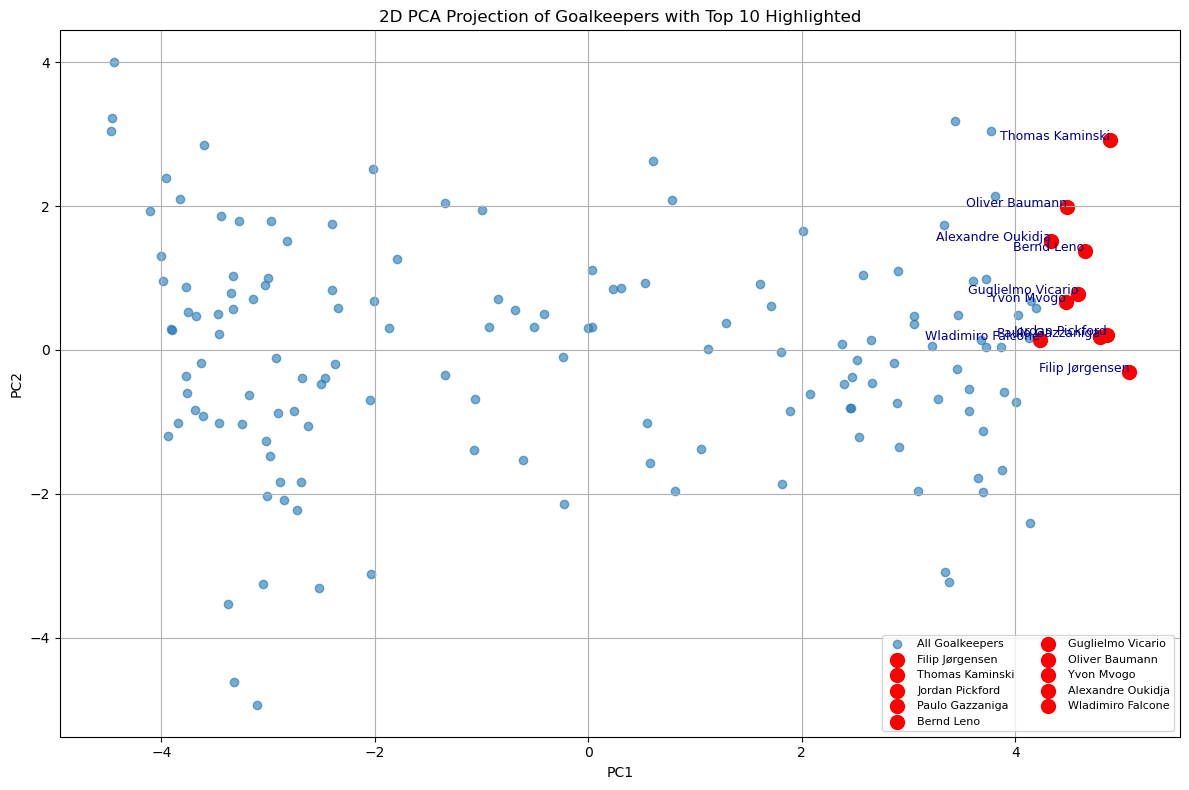

In [19]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_goalkeepers.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

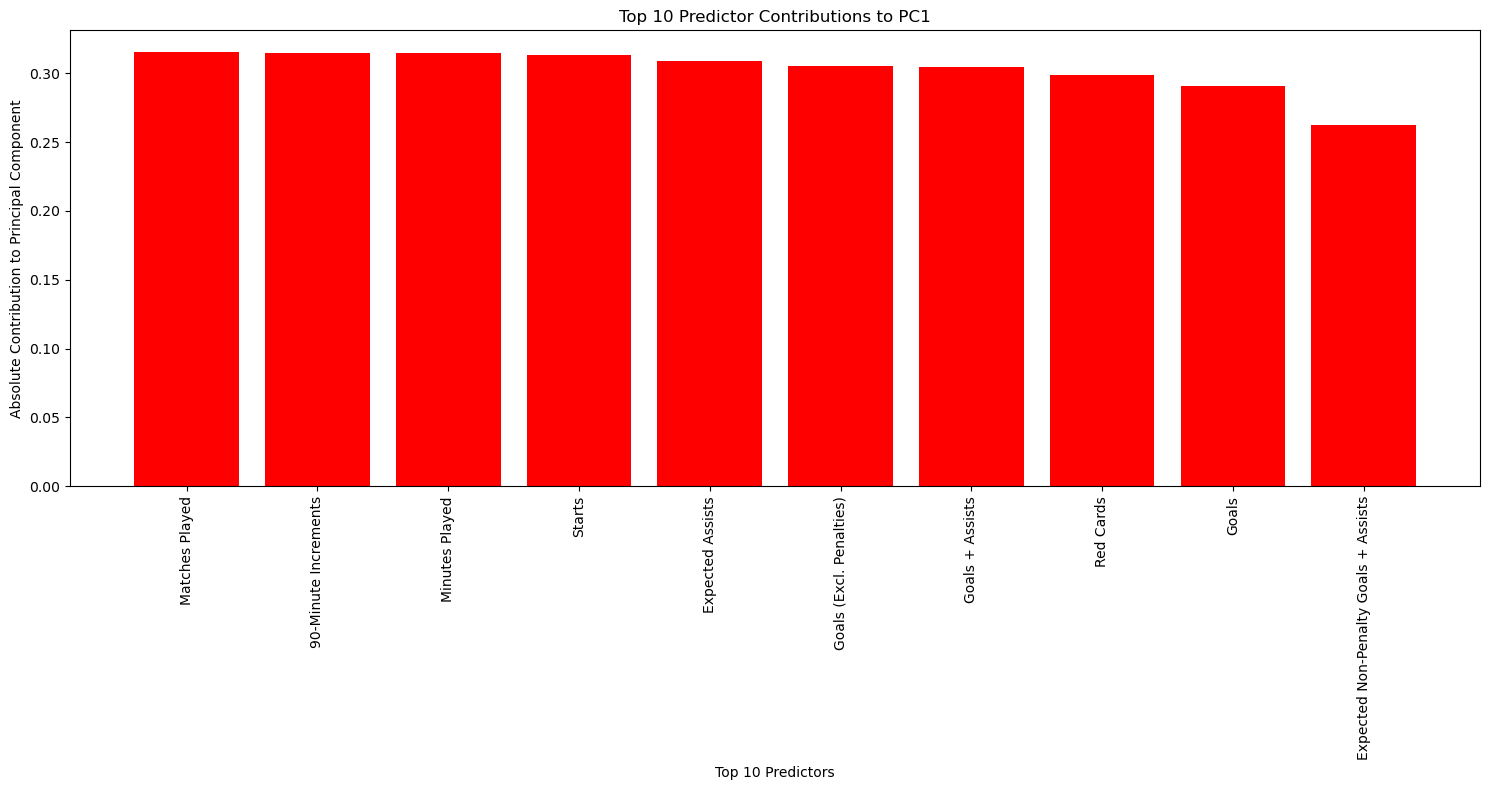

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-10:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 10 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 10 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="forward-pca-2"></a>

### <div class='subsection'>8.4 Forward PCA</div>


In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

The total number of components is: 64.
The number of components required to explain 95% of the variance is: 18.


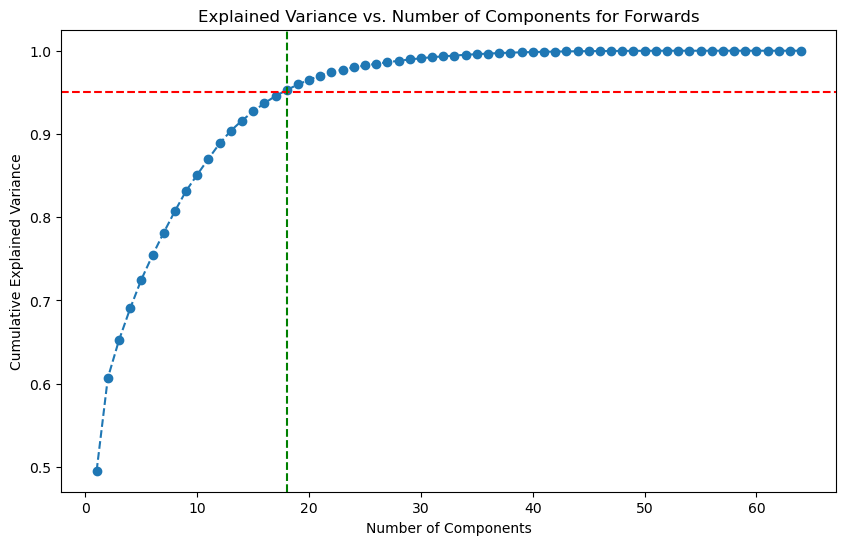

In [21]:
forwards_train, forwards_test = train_test_split(forwards, test_size=0.2, random_state=42)

forwards_numeric_train = forwards_train.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()
forwards_numeric_test = forwards_test.select_dtypes(include='number').drop(columns=['Market Value (Euros)'], errors='ignore').dropna()


forwards_train = forwards_train.loc[forwards_numeric_train.index].reset_index(drop=True)
forwards_test = forwards_test.loc[forwards_numeric_test.index].reset_index(drop=True)


forwards_y_train = np.log1p(forwards_train['Market Value (Euros)'])
forwards_y_test = np.log1p(forwards_test['Market Value (Euros)'])

pca = PCA()
pca1 = PCA()
forwards_pca= pca.fit_transform(forwards_numeric_train)
forwards_pca1= pca1.fit_transform(forwards_numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

forwards_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {forwards_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=forwards_valid_components, color='g', linestyle='--', label=f'{forwards_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()

In order to explain 95% of the variance, only 18 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [22]:
forwards_train['PC1'] = forwards_pca[:, 0]
forwards_train['PC2'] = forwards_pca[:, 1]

forwards_test['PC1'] = forwards_pca1[:, 0]
forwards_test['PC2'] = forwards_pca1[:, 1]

top_forwards = forwards_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_forwards[['Player', 'PC1']])

Top 10 defenders based on PC1:
                  Player     PC1
265          Cole Palmer  18.769
345          Bukayo Saka  18.667
419           Phil Foden  17.444
489         Matìas Soulé  16.840
77         Kylian Mbappé  16.500
280        Mohamed Salah  15.412
148                Sávio  14.398
308  Romain Del Castillo  14.233
349        Son Heung-min  14.086
256           Harry Kane  14.024


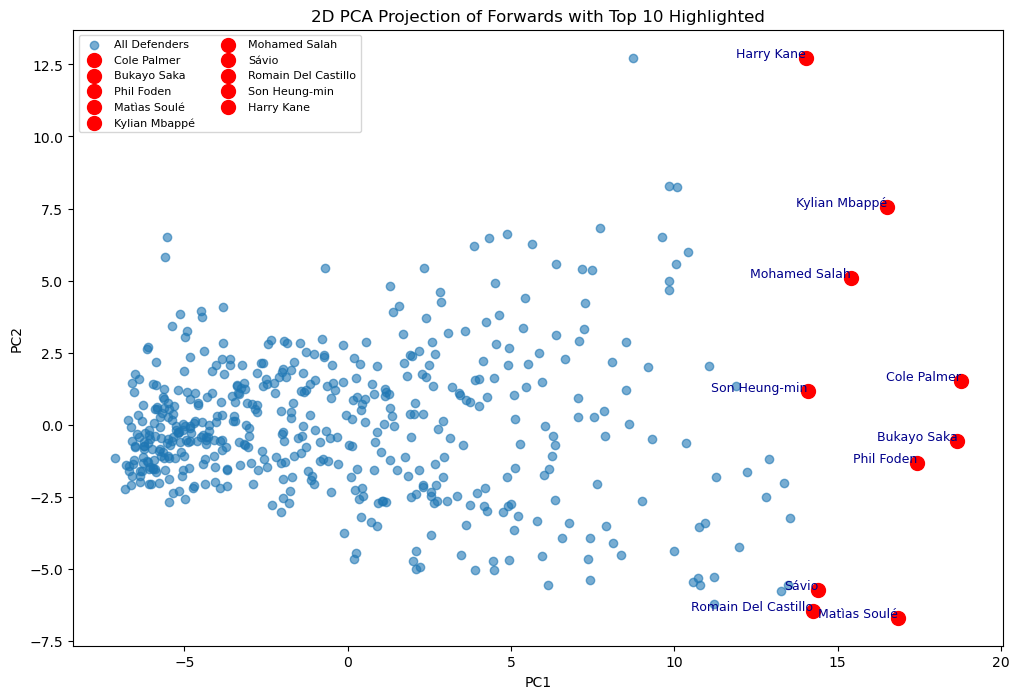

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(forwards_pca[:, 0], forwards_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

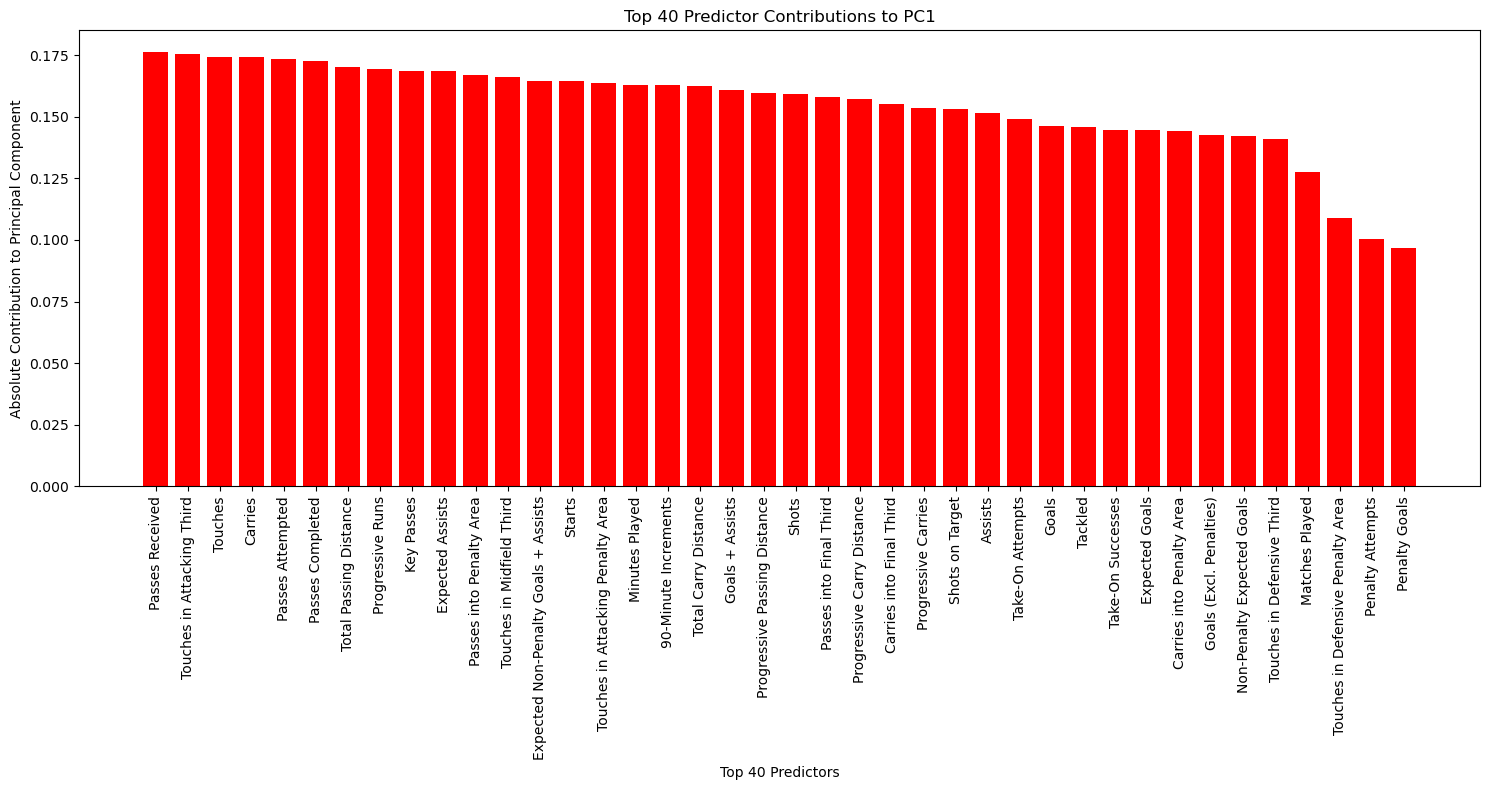

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-min(40, len(forwards_train.columns)):][::-1]
top_features = forwards_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models"></a>

## <div class='section'>Section 9: Baseline Modeling</div>

[Return to contents](#contents)


### <a id="baseline-models-defense-dt"></a> 9.1.A Defensive Player Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


pca = PCA(n_components=defender_valid_components)
x_train = pca.fit_transform(defender_numeric_train)
x_test = pca.transform(defender_numeric_test)
y_train = defender_y_train
y_test = defender_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

defenders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.0495
Cross-Validation R²: -0.0653

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0495
Cross-Validation R²: -0.0653

Test R²: 0.0058
Test MSE: 33.1727


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_83143/549589381.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)


model     r2     mse
0  Decision Tree  0.006  33.173

The regression results indicate that the decision tree model struggles to generalize beyond the training data. Although the training R² of approximately 0.2496 suggests that the model can capture some patterns within the training set, the cross-validation R² of around 0.14 shows a substantial drop in performance, indicating overfitting. More concerning is the R² (0.099) on the test set, which implies that the model’s predictions are worse than a simple baseline that always predicts the mean value. This poor generalization, combined with the elevated training scores, strongly suggests that the decision tree regressor in its current form is not well suited for this annual wage prediction task. Further model refinement, feature engineering, or alternative modeling approaches are necessary to achieve more reliable and meaningful results.

### <a id="baseline-models-defense-bagging"></a> 9.1.B Defense Player Bagging Model

In [30]:
from sklearn.ensemble import BaggingRegressor

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)


test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.0495
Cross-Validation R²: -0.0653

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0495
Cross-Validation R²: -0.0653

Test R² (Bagging): 0.0215
Test MSE (Bagging): 32.6501


model     r2     mse
0             Decision Tree  0.006  33.173
1  Bagging (Decision Trees)  0.021  32.650

The results suggest that while the decision trees can capture some variance in the training data (with a training R² around 0.24) and achieve low cross-validation scores (just above 0.20), the generalization to unseen data remains challenging. Even after employing bagging, the test R² is only about 0.202, indicating that the ensemble model explains very little of the variance in the test set. The test MSE of approximately 0.450 further highlights the gap between training and testing performance, suggesting that these models, in their current configurations, have limited predictive power for this particular task.

### <a id="baseline-models-defense-logreg"></a> 9.1.C Defensive Player Linear Regression Model

In [31]:
from sklearn.linear_model import LinearRegression

# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_linear_regression.csv', index=False)


model     r2     mse
0             Decision Tree  0.006  33.173
1  Bagging (Decision Trees)  0.021  32.650
2                 LinearReg  0.007  33.142

### <a id="baseline-models-defense-rf"></a> 9.1.D Defensive Player Random Forest Model

In [32]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(x_train, y_train)

pred = rf_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Random Forest Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Random Forest'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_rf_baseline.csv', index=False)


Baseline Random Forest Results:
Test R²: 0.0178
Test MSE: 32.7753


model     r2     mse
0             Decision Tree  0.006  33.173
1  Bagging (Decision Trees)  0.021  32.650
2                 LinearReg  0.007  33.142
3             Random Forest  0.018  32.775

### <a id="baseline-models-defense-gb"></a> 9.1.E Defensive Gradient Boosting Forest Model

In [33]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(x_train, y_train)

pred = gb_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Gradient Boosting Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_gb_baseline.csv', index=False)

Baseline Gradient Boosting Results:
Test R²: -0.0721
Test MSE: 35.7732


model     r2     mse
0             Decision Tree  0.006  33.173
1  Bagging (Decision Trees)  0.021  32.650
2                 LinearReg  0.007  33.142
3             Random Forest  0.018  32.775
4         Gradient Boosting -0.072  35.773

### <a id="baseline-models-defense-mix"></a> 9.1.F Defensive Mixture of Experts Foest Model

In [34]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(x_train, y_train)
expert2.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    expert1.predict(x_train),
    expert2.predict(x_train),
])

y_train_array = np.array(y_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = expert1.predict(x_test)
expert2_preds = expert2.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("Mixture of Experts Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Mixture of Experts (Logistic Gating)'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('defenders_predictions_mixture_of_experts.csv', index=False)


Mixture of Experts Results:
Test R²: -0.0045
Test MSE: 33.5178


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2     mse
0                         Decision Tree  0.006  33.173
1              Bagging (Decision Trees)  0.021  32.650
2                             LinearReg  0.007  33.142
3                         Random Forest  0.018  32.775
4                     Gradient Boosting -0.072  35.773
5  Mixture of Experts (Logistic Gating) -0.004  33.518

When using linear regression, we see that it is better at predicting the league of the players compared to the other models, highlighting that it could be an optimal option for our model.

<a id="baseline-models-midfielder"></a>

## <div class='sub-section'>9.2: Midfielder Model Baselines (Decision Tree, Bagging, Logistic Regression)

### <a id="baseline-models-midfielder-dt"></a> 9.2.A Midfielder Player Decision Tree Baseline Model

In [35]:
pca = PCA(n_components=midfielders_valid_components)
x_train = pca.fit_transform(midfielders_numeric_train)
x_test = pca.transform(midfielders_numeric_test)
y_train = midfielders_y_train
y_test = midfielders_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

midfielders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.0595
Cross-Validation R²: -0.1013

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0595
Cross-Validation R²: -0.0974

Test R²: -0.0687
Test MSE: 50.3251


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_83143/183764107.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)


model     r2     mse
0  Decision Tree -0.069  50.325

The midfielder model's performance metrics reveal a substantial discrepancy between training and evaluation phases, highlighting significant challenges in effectively predicting annual wages. With a training R² of approximately 0.29, the Decision Tree Regressor demonstrates a weak ability to explain the variance within the training dataset, suggesting that the model does not capture meaningful patterns from the training data. This performance translates to unseen data, as evidenced by the cross-validation R² values of around 0.1808 and a test R² of -0.06. The negative R² on the test set indicates that the model is performing worse than a simple baseline that always predicts the mean wage, underscoring severe prediction issues. Additionally, the test Mean Squared Error (MSE) of 0.484 further emphasizes the model's poor predictive accuracy.

### <a id="baseline-models-midfielder-bagging"></a> 9.2.B Midfielder Player Bagging Baseline Model

In [36]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.0595
Cross-Validation R²: -0.1013

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0595
Cross-Validation R²: -0.0974

Test R² (Bagging): -0.0051
Test MSE (Bagging): 47.3304


model     r2     mse
0             Decision Tree -0.069  50.325
1  Bagging (Decision Trees) -0.005  47.330

The decision tree performed worse for the midfielders than the defenders. The r^2 is negative, indicating that the model performs worse than a naive model.

### <a id="baseline-models-midfielder-logreg"></a> 9.2.C Midfielder Player Linear Regression Baseline Model

In [37]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_linear_regression.csv', index=False)

model         r2     mse
0             Decision Tree -6.870e-02  50.325
1  Bagging (Decision Trees) -5.100e-03  47.330
2                 LinearReg -4.000e-04  47.112

### <a id="baseline-models-midfielder-rf"></a> 9.2.D Midfielder Player Random Forest Baseline Model

In [38]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(x_train, y_train)

pred = rf_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Random Forest Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Random Forest'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_rf_baseline.csv', index=False)


Baseline Random Forest Results:
Test R²: -0.0427
Test MSE: 49.1019


model         r2     mse
0             Decision Tree -6.870e-02  50.325
1  Bagging (Decision Trees) -5.100e-03  47.330
2                 LinearReg -4.000e-04  47.112
3             Random Forest -4.270e-02  49.102

### <a id="baseline-models-midfielder-gradient"></a> 9.2.E Midfielder Player Gradient Boosting Baseline Model

In [39]:
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=100)  # Baseline parameters
gb_model.fit(x_train, y_train)

# Predict on the test set
pred = gb_model.predict(x_test)

# Evaluate the model
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Gradient Boosting Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Update results DataFrame
new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)

# Save predictions to CSV
pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('midfielders_predictions_gb_baseline.csv', index=False)

# Display updated results
display(midfielders_results_df)


Baseline Gradient Boosting Results:
Test R²: -0.1791
Test MSE: 55.5267


model         r2     mse
0             Decision Tree -6.870e-02  50.325
1  Bagging (Decision Trees) -5.100e-03  47.330
2                 LinearReg -4.000e-04  47.112
3             Random Forest -4.270e-02  49.102
4         Gradient Boosting -1.791e-01  55.527

### <a id="baseline-models-midfielder-mix"></a> 9.2.F Midfielder Player Mixture of Experts Baseline Model

In [40]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(x_train, y_train)
expert2.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    expert1.predict(x_train),
    expert2.predict(x_train),
])

y_train_array = np.array(y_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = expert1.predict(x_test)
expert2_preds = expert2.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("Mixture of Experts Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Mixture of Experts (Logistic Gating)'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)

pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': final_preds})
pred_df.to_csv('midfielders_predictions_mixture_of_experts.csv', index=False)

display(midfielders_results_df)



Mixture of Experts Results:
Test R²: -0.0816
Test MSE: 50.9334


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model         r2     mse
0                         Decision Tree -6.870e-02  50.325
1              Bagging (Decision Trees) -5.100e-03  47.330
2                             LinearReg -4.000e-04  47.112
3                         Random Forest -4.270e-02  49.102
4                     Gradient Boosting -1.791e-01  55.527
5  Mixture of Experts (Logistic Gating) -8.160e-02  50.933

Similar to the defenders data set, logistic regression outperforms the decision tree in terms of various accuracy metrics, indicating it's strength as a model. 

<a id="baseline-models-goalkeeper"></a>

## <div class='sub-section'>9.3: Goalkeeper Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>



### <a id="baseline-models-goalkeeper-dt"></a> 9.3.A Goalkeeper Decision Tree Baseline Model

In [41]:
pca = PCA(n_components=goalkeepers_valid_components)
x_train = pca.fit_transform(goalkeepers_numeric_train)
x_test = pca.transform(goalkeepers_numeric_test)
y_train = goalkeepers_y_train
y_test = goalkeepers_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

goalkeepers_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.1361
Cross-Validation R²: -0.3295

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.1361
Cross-Validation R²: -0.3295

Test R²: -0.0751
Test MSE: 42.5016


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_83143/1508083288.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)


model     r2     mse
0  Decision Tree -0.075  42.502

The Decision Tree model’s performance metrics reveal that the learned patterns do not generalize well. Although the training R² is around 0.231, indicating that the model captures some variance in the training data, but barely performs better than a naive model (r^2 of 0). The substantial drop from training to cross-validation (and later to test) underscores severe overfitting and suggests that the model is not reliably capturing the underlying relationships necessary to predict goalkeeper wages. The test MSE of approximately 2.39 further supports the notion that the current model configuration is far from satisfactory, and that more robust feature engineering, hyperparameter tuning, or entirely different modeling approaches may be necessary.

### <a id="baseline-models-goalkeeper-bagging"></a> 9.3.B Goalkeeper Bagging Baseline Model

In [42]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.1361
Cross-Validation R²: -0.3295

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.1361
Cross-Validation R²: -0.3295

Test R² (Bagging): -0.0360
Test MSE (Bagging): 40.9537


model     r2     mse
0             Decision Tree -0.075  42.502
1  Bagging (Decision Trees) -0.036  40.954

The bagging model performs very well on the goalkeeper data relative to the decision tree model.

### <a id="baseline-models-goalkeeper-logreg"></a> 9.3.C Goalkeeper Linear Regression Baseline Model

In [43]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_linear_regression.csv', index=False)


model     r2     mse
0             Decision Tree -0.075  42.502
1  Bagging (Decision Trees) -0.036  40.954
2                 LinearReg -0.079  42.654

### <a id="baseline-models-goalkeeper-rf"></a> 9.3.D Goalkeeper Random Forest Baseline Model

In [44]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(x_train, y_train)

pred = rf_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Random Forest Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Random Forest'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_rf_baseline.csv', index=False)


Baseline Random Forest Results:
Test R²: -0.0509
Test MSE: 41.5422


model     r2     mse
0             Decision Tree -0.075  42.502
1  Bagging (Decision Trees) -0.036  40.954
2                 LinearReg -0.079  42.654
3             Random Forest -0.051  41.542

### <a id="baseline-models-goalkeeper-gb"></a> 9.3.E Goalkeeper Gradient Boosting Baseline Model

In [45]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(x_train, y_train)

pred = gb_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Gradient Boosting Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_gb_baseline.csv', index=False)

Baseline Gradient Boosting Results:
Test R²: -0.2165
Test MSE: 48.0881


model     r2     mse
0             Decision Tree -0.075  42.502
1  Bagging (Decision Trees) -0.036  40.954
2                 LinearReg -0.079  42.654
3             Random Forest -0.051  41.542
4         Gradient Boosting -0.216  48.088

### <a id="baseline-models-goalkeeper-mix"></a> 9.3.F Goalkeeper Mixture of Experts Baseline Model

In [46]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(x_train, y_train)
expert2.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    expert1.predict(x_train),
    expert2.predict(x_train),
])

y_train_array = np.array(y_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = expert1.predict(x_test)
expert2_preds = expert2.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("Mixture of Experts Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Mixture of Experts (Logistic Gating)'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('goalkeepers_predictions_mixture_of_experts.csv', index=False)

Mixture of Experts Results:
Test R²: -0.1069
Test MSE: 43.7577


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2     mse
0                         Decision Tree -0.075  42.502
1              Bagging (Decision Trees) -0.036  40.954
2                             LinearReg -0.079  42.654
3                         Random Forest -0.051  41.542
4                     Gradient Boosting -0.216  48.088
5  Mixture of Experts (Logistic Gating) -0.107  43.758

It appears that the random forest model is the best model for the goalkeeper data thus far although it still has a lot of room for improvement given it's very low r2 score. The bagging model is next best with a higher MSE and a lower r2 score than the RF model. The linear regression model is the worst model, having the lowest r2 score.

<a id="baseline-models-forward"></a>

## <div class='sub-section'>9.4: Forward Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>


### <a id="baseline-models-forward-dt"></a> 9.4.A Forward Player Decision Tree Baseline Model

In [47]:
pca = PCA(n_components=forwards_valid_components)
x_train = pca.fit_transform(forwards_numeric_train)
x_test = pca.transform(forwards_numeric_test)
y_train = forwards_y_train
y_test = forwards_y_test

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
else:
    model = model_tree_friedman

pred = model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))

forwards_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - Now these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_regression.csv', index=False)

================ [Squared Error (Using PCA)] ================
Training R²: 0.0579
Cross-Validation R²: -0.0259

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0579
Cross-Validation R²: -0.0259

Test R²: -0.0764
Test MSE: 45.4221


/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_83143/2798168860.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)


model     r2     mse
0  Decision Tree -0.076  45.422

The decision tree model’s performance metrics indicate significant challenges in capturing and generalizing the underlying patterns necessary for accurate wage prediction. With a training R² of approximately 0.59, the Decision Tree Regressor demonstrates a moderate ability to explain the variance within the training dataset. However, this promising performance sharply declines during cross-validation, where the R² plummets to -1.19, and further deteriorates on the test set with an R² of -0.19. Negative R² values in both cross-validation and testing phases signify that the model performs worse than a naive baseline that simply predicts the mean wage, highlighting severe overfitting issues. Additionally, the test Mean Squared Error (MSE) of 1.06 underscores the model's poor predictive accuracy.

### <a id="baseline-models-forward-bagging"></a> 9.4.B Forward Player Bagging Baseline Model

In [48]:
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        # Create a regression tree
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth)
        
        # cross_val_score by default for regressors returns the R² score
        scores = cross_val_score(dt, X=x_train, y=y_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

# Identify best depths for both criteria
best_squared_idx = np.argmax(df_squared['mean_cv'])
best_friedman_idx = np.argmax(df_friedman['mean_cv'])

best_depth_squared = df_squared['depth'].iloc[best_squared_idx]
best_depth_friedman = df_friedman['depth'].iloc[best_friedman_idx]

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error')
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse')

# Fit the models on the training data
model_tree_squared.fit(x_train, y_train)
model_tree_friedman.fit(x_train, y_train)

# Evaluate on the training set
train_pred_squared = model_tree_squared.predict(x_train)
train_pred_friedman = model_tree_friedman.predict(x_train)

r2_train_squared = r2_score(y_train, train_pred_squared)
r2_train_friedman = r2_score(y_train, train_pred_friedman)

cv_r2_squared = df_squared['mean_cv'].iloc[best_squared_idx]
cv_r2_friedman = df_friedman['mean_cv'].iloc[best_friedman_idx]

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

# Select the best model based on cross-validation R²
if cv_r2_squared >= cv_r2_friedman:
    best_dt = model_tree_squared
else:
    best_dt = model_tree_friedman

# Now implement bagging with the best DT as the base estimator
bagged_model = BaggingRegressor(
    estimator=best_dt, 
    n_estimators=50,   # You can choose a different number of estimators
    random_state=42,
    n_jobs=-1
)

bagged_model.fit(x_train, y_train)
pred = bagged_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
print("\nTest R² (Bagging): {:.4f}".format(test_r2))
print("Test MSE (Bagging): {:.4f}".format(test_mse))

new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_regression_bagging.csv', index=False)


================ [Squared Error (Using PCA)] ================
Training R²: 0.0579
Cross-Validation R²: -0.0259

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.0579
Cross-Validation R²: -0.0259

Test R² (Bagging): -0.0585
Test MSE (Bagging): 44.6700


model     r2     mse
0             Decision Tree -0.076  45.422
1  Bagging (Decision Trees) -0.059  44.670

The bagging model is worse all around than the decision tree model.

### <a id="baseline-models-forward-logreg"></a> 9.4.C Forward Player Linear Regression Baseline Model

In [49]:
# Initialize and fit a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Predict continuous values
pred = lr.predict(x_test)

# Compute regression metrics
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

# Create a new row for the results DataFrame
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2,4)],
    'mse': [round(mse,4)],
})

# Concatenate with existing results
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

# Save predictions - these predictions are continuous values (annual wages)
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('forwards_predictions_linear_regression.csv', index=False)



model     r2     mse
0             Decision Tree -0.076  45.422
1  Bagging (Decision Trees) -0.059  44.670
2                 LinearReg -0.075  45.380

### <a id="baseline-models-forward-rf"></a> 9.4.D Forward Player Random Forest Baseline Model

In [50]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  
rf_model.fit(x_train, y_train)

rf_predictions = rf_model.predict(x_test)

test_r2 = r2_score(y_test, rf_predictions)
test_mse = mean_squared_error(y_test, rf_predictions)

print("Baseline Random Forest Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Random Forest'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)

display(forwards_results_df)

pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': rf_predictions})
pred_df.to_csv('forwards_predictions_rf_baseline.csv', index=False)


Baseline Random Forest Results:
Test R²: -0.1618
Test MSE: 49.0287


model     r2     mse
0             Decision Tree -0.076  45.422
1  Bagging (Decision Trees) -0.059  44.670
2                 LinearReg -0.075  45.380
3             Random Forest -0.162  49.029

### <a id="baseline-models-forward-gb"></a> 9.4.E Forward Player Gradient Boosting Baseline Model

In [51]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(x_train, y_train)

pred = gb_model.predict(x_test)

test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("Baseline Gradient Boosting Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': rf_predictions})
pred_df.to_csv('forwards_predictions_gb_baseline.csv', index=False)

Baseline Gradient Boosting Results:
Test R²: -0.1633
Test MSE: 49.0902


model     r2     mse
0             Decision Tree -0.076  45.422
1  Bagging (Decision Trees) -0.059  44.670
2                 LinearReg -0.075  45.380
3             Random Forest -0.162  49.029
4         Gradient Boosting -0.163  49.090

### <a id="baseline-models-forward-mix"></a> 9.4.F Forward Player Mixture of Experts Baseline Model

In [52]:
expert1 = gb_model
expert2 = rf_model

expert1.fit(x_train, y_train)
expert2.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    expert1.predict(x_train),
    expert2.predict(x_train),
])

y_train_array = np.array(y_train)

gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = expert1.predict(x_test)
expert2_preds = expert2.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("Mixture of Experts Results:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Mixture of Experts (Logistic Gating)'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': rf_predictions})
pred_df.to_csv('forwards_predictions_mixture_of_experts.csv', index=False)

Mixture of Experts Results:
Test R²: -0.1419
Test MSE: 48.1894


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2     mse
0                         Decision Tree -0.076  45.422
1              Bagging (Decision Trees) -0.059  44.670
2                             LinearReg -0.075  45.380
3                         Random Forest -0.162  49.029
4                     Gradient Boosting -0.163  49.090
5  Mixture of Experts (Logistic Gating) -0.142  48.189

On the forwards, the linear regression performs the best out of the 5 models, although it's r2 score can be heavily improved.

<a id="tuning-model"></a>

## <div class='section'>Section 10: Final Model Tuning</div>

[Return to contents](#contents)

Overall, the models did not perform very well on the test sets. This can be due to the fact that salary is notoriously hard to predict; there are many other factors that play into the salary of a player, such as the branding and popularity of the player. While acknowlodging the difficulties in pedicting salary data, we plan to utilize the best performing models in order to predict salary, in hope of capturing some of the trends associated with salary and player performance. 

The best model for each position was as follows:

Defenders- Bagging

Midfielders- Bagging

Goalkeepers- Mixture of Experts

Forwards- Bagging




<a id="tune-defenders"></a>

### <div class='sub-section'>10.1: Defenders Tuning: Bagging Model</div>

In [53]:
pca = PCA(n_components=defender_valid_components)
x_train = pca.fit_transform(defender_numeric_train)
x_test = pca.transform(defender_numeric_test)
y_train = defender_y_train
y_test = defender_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))

tuned_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])

new_row = pd.DataFrame({
    'model': ['Defenders: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})
tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': defender_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_defenders_predictions.csv', index=False)


Best Parameters:
{'estimator__criterion': 'friedman_mse', 'estimator__max_depth': 5, 'max_features': 0.5, 'n_estimators': 100}

Test R² (Tuned Bagging): 0.0116
Test MSE (Tuned Bagging): 32.9803


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/var/folders/gf/xxqycrk54d9c_hw_hkbc1zgh0000gn/T/ipykernel_83143/3512900588.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)


model     r2    mse
0  Defenders: Tuned Bagging (Decision Trees)  0.012  32.98

<a id="tune-midfielders"></a>

### <div class='sub-section'>10.2: Midfielders Tuning: Bagging Model</div>

In [54]:
pca = PCA(n_components=midfielders_valid_components)
x_train = pca.fit_transform(midfielders_numeric_train)
x_test = pca.transform(midfielders_numeric_test)
y_train = midfielders_y_train
y_test = midfielders_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))


new_row = pd.DataFrame({
    'model': ['Midfielders: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_midfielders_praedictions.csv', index=False)

Best Parameters:
{'estimator__criterion': 'friedman_mse', 'estimator__max_depth': 5, 'max_features': 0.5, 'n_estimators': 50}

Test R² (Tuned Bagging): -0.0205
Test MSE (Tuned Bagging): 48.0587


model     r2     mse
0    Defenders: Tuned Bagging (Decision Trees)  0.012  32.980
1  Midfielders: Tuned Bagging (Decision Trees) -0.021  48.059

<a id="tune-goalkeepers"></a>

### <div class='sub-section'>10.3: Goalkeepers Tuning: Mixture of Experts Model</div>

In [55]:
pca = PCA(n_components=goalkeepers_valid_components)
x_train = pca.fit_transform(goalkeepers_numeric_train)
x_test = pca.transform(goalkeepers_numeric_test)
y_train = goalkeepers_y_train
y_test = goalkeepers_y_test

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'max_features': [0.5, 0.7, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
gb_grid_search.fit(x_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

print("Best Parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
rf_grid_search.fit(x_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

print("Best Parameters for Random Forest:")
print(rf_grid_search.best_params_)

best_gb_model.fit(x_train, y_train)
best_rf_model.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    best_gb_model.predict(x_train),
    best_rf_model.predict(x_train),
])

y_train_array = np.array(y_train)
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
gating_network.fit(x_train, gating_labels)

expert1_preds = best_gb_model.predict(x_test)
expert2_preds = best_rf_model.predict(x_test)

gating_weights = gating_network.predict_proba(x_test)

final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)

print("\nMixture of Experts Results (with Tuned Experts):")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Goalkeepers: Tuned Mixture of Experts'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'Predicted_Wage': final_preds})
pred_df.to_csv('tuned_goalkeepers_predictions.csv', index=False)

Best Parameters for Gradient Boosting:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Parameters for Random Forest:
{'max_depth': 5, 'max_features': 0.5, 'n_estimators': 50}

Mixture of Experts Results (with Tuned Experts):
Test R²: -0.0350
Test MSE: 40.9134


/Users/benistaowusu-amo/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2     mse
0    Defenders: Tuned Bagging (Decision Trees)  0.012  32.980
1  Midfielders: Tuned Bagging (Decision Trees) -0.021  48.059
2        Goalkeepers: Tuned Mixture of Experts -0.035  40.913

<a id="tune-forwarders"></a>

### <div class='sub-section'>10.4: Forwards Tuning: Bagging Model</div>

In [56]:
pca = PCA(n_components=forwards_valid_components)
x_train = pca.fit_transform(forwards_numeric_train)
x_test = pca.transform(forwards_numeric_test)
y_train = forwards_y_train
y_test = forwards_y_test

dt_base = DecisionTreeRegressor()

param_grid = {
    'estimator__criterion': ['squared_error', 'friedman_mse'],  
    'estimator__max_depth': [5, 10, 15],  
    'n_estimators': [10, 50, 100],  
    'max_features': [0.5, 0.7, 1.0],  
}

bagging_model = BaggingRegressor(
    estimator=dt_base,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)

print("\nTest R² (Tuned Bagging): {:.4f}".format(test_r2))
print("Test MSE (Tuned Bagging): {:.4f}".format(test_mse))


new_row = pd.DataFrame({
    'model': ['Forwards: Tuned Bagging (Decision Trees)'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'Predicted_Wage': pred})
pred_df.to_csv('tuned_forwards_predictions.csv', index=False)

Best Parameters:
{'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'max_features': 0.7, 'n_estimators': 50}

Test R² (Tuned Bagging): -0.0550
Test MSE (Tuned Bagging): 44.5196


model     r2     mse
0    Defenders: Tuned Bagging (Decision Trees)  0.012  32.980
1  Midfielders: Tuned Bagging (Decision Trees) -0.021  48.059
2        Goalkeepers: Tuned Mixture of Experts -0.035  40.913
3     Forwards: Tuned Bagging (Decision Trees) -0.055  44.520

NEW EDITS

In [57]:
# Load market value data
market_values = pd.read_csv("stats/market_values.csv")

# Preprocess Defenders Dataset
defender_data = pd.read_csv("stats/DF_relevant_stats.csv")
defender_data = pd.merge(defender_data, market_values, on='Player', how='inner')
X_def = defender_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_def = np.log1p(defender_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_def_imputed = imputer.fit_transform(X_def)
scaler = StandardScaler()
X_def_scaled = scaler.fit_transform(X_def_imputed)
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X_def_scaled, y_def, test_size=0.2, random_state=42)

# Preprocess Midfielders Dataset
midfielder_data = pd.read_csv("stats/MF_relevant_stats.csv")
midfielder_data = pd.merge(midfielder_data, market_values, on='Player', how='inner')
X_mid = midfielder_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_mid = np.log1p(midfielder_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_mid_imputed = imputer.fit_transform(X_mid)
scaler = StandardScaler()
X_mid_scaled = scaler.fit_transform(X_mid_imputed)
X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(X_mid_scaled, y_mid, test_size=0.2, random_state=42)

# Preprocess Goalkeepers Dataset
goalkeeper_data = pd.read_csv("stats/GK_relevant_stats.csv")
goalkeeper_data = pd.merge(goalkeeper_data, market_values, on='Player', how='inner')
X_gk = goalkeeper_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_gk = np.log1p(goalkeeper_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_gk_imputed = imputer.fit_transform(X_gk)
scaler = StandardScaler()
X_gk_scaled = scaler.fit_transform(X_gk_imputed)
X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(X_gk_scaled, y_gk, test_size=0.2, random_state=42)

# Preprocess Forwards Dataset
forward_data = pd.read_csv("stats/FW_relevant_stats.csv")
forward_data = pd.merge(forward_data, market_values, on='Player', how='inner')
X_fw = forward_data.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
y_fw = np.log1p(forward_data['Market Value (Euros)'])
imputer = SimpleImputer(strategy='mean')
X_fw_imputed = imputer.fit_transform(X_fw)
scaler = StandardScaler()
X_fw_scaled = scaler.fit_transform(X_fw_imputed)
X_train_fw, X_test_fw, y_train_fw, y_test_fw = train_test_split(X_fw_scaled, y_fw, test_size=0.2, random_state=42)

# Apply PCA for all datasets
print("\n=== Applying PCA ===")
pca_def = PCA(n_components=0.95)
X_train_def_pca = pca_def.fit_transform(X_train_def)
X_test_def_pca = pca_def.transform(X_test_def)
print(f"[Defenders] Explained Variance by Components: {pca_def.explained_variance_ratio_}")

pca_mid = PCA(n_components=0.95)
X_train_mid_pca = pca_mid.fit_transform(X_train_mid)
X_test_mid_pca = pca_mid.transform(X_test_mid)
print(f"[Midfielders] Explained Variance by Components: {pca_mid.explained_variance_ratio_}")

pca_gk = PCA(n_components=0.95)
X_train_gk_pca = pca_gk.fit_transform(X_train_gk)
X_test_gk_pca = pca_gk.transform(X_test_gk)
print(f"[Goalkeepers] Explained Variance by Components: {pca_gk.explained_variance_ratio_}")

pca_fw = PCA(n_components=0.95)
X_train_fw_pca = pca_fw.fit_transform(X_train_fw)
X_test_fw_pca = pca_fw.transform(X_test_fw)
print(f"[Forwards] Explained Variance by Components: {pca_fw.explained_variance_ratio_}")

# Train and Evaluate Models for Defenders
print("\n=== Training Models for Defenders ===")
rf_model_def = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_def.fit(X_train_def_pca, y_train_def)
y_pred_rf_def = rf_model_def.predict(X_test_def_pca)
r2_rf_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
mse_rf_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
mae_rf_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_rf_def))
print(f"[Defenders] Random Forest Model Performance:\nR^2: {r2_rf_def:.4f}\nMSE: {mse_rf_def:.4f}\nMAE: {mae_rf_def:.4f}\n")

gb_model_def = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_def.fit(X_train_def_pca, y_train_def)
y_pred_gb_def = gb_model_def.predict(X_test_def_pca)
r2_gb_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
mse_gb_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
mae_gb_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_gb_def))
print(f"[Defenders] Gradient Boosting Model Performance:\nR^2: {r2_gb_def:.4f}\nMSE: {mse_gb_def:.4f}\nMAE: {mae_gb_def:.4f}\n")

lr_model_def = LinearRegression()
lr_model_def.fit(X_train_def_pca, y_train_def)
y_pred_lr_def = lr_model_def.predict(X_test_def_pca)
r2_lr_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
mse_lr_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
mae_lr_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_lr_def))
print(f"[Defenders] Linear Regression Model Performance:\nR^2: {r2_lr_def:.4f}\nMSE: {mse_lr_def:.4f}\nMAE: {mae_lr_def:.4f}\n")

bag_model_def = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_def.fit(X_train_def_pca, y_train_def)
y_pred_bag_def = bag_model_def.predict(X_test_def_pca)
r2_bag_def = r2_score(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
mse_bag_def = mean_squared_error(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
mae_bag_def = mean_absolute_error(np.expm1(y_test_def), np.expm1(y_pred_bag_def))
print(f"[Defenders] Bagging Regressor Model Performance:\nR^2: {r2_bag_def:.4f}\nMSE: {mse_bag_def:.4f}\nMAE: {mae_bag_def:.4f}\n")

# Train and Evaluate Models for Midfielders
print("\n=== Training Models for Midfielders ===")
rf_model_mid = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_rf_mid = rf_model_mid.predict(X_test_mid_pca)
r2_rf_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
mse_rf_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
mae_rf_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_rf_mid))
print(f"[Midfielders] Random Forest Model Performance:\nR^2: {r2_rf_mid:.4f}\nMSE: {mse_rf_mid:.4f}\nMAE: {mae_rf_mid:.4f}\n")

gb_model_mid = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_gb_mid = gb_model_mid.predict(X_test_mid_pca)
r2_gb_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
mse_gb_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
mae_gb_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_gb_mid))
print(f"[Midfielders] Gradient Boosting Model Performance:\nR^2: {r2_gb_mid:.4f}\nMSE: {mse_gb_mid:.4f}\nMAE: {mae_gb_mid:.4f}\n")

lr_model_mid = LinearRegression()
lr_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_lr_mid = lr_model_mid.predict(X_test_mid_pca)
r2_lr_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
mse_lr_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
mae_lr_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_lr_mid))
print(f"[Midfielders] Linear Regression Model Performance:\nR^2: {r2_lr_mid:.4f}\nMSE: {mse_lr_mid:.4f}\nMAE: {mae_lr_mid:.4f}\n")

bag_model_mid = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_mid.fit(X_train_mid_pca, y_train_mid)
y_pred_bag_mid = bag_model_mid.predict(X_test_mid_pca)
r2_bag_mid = r2_score(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
mse_bag_mid = mean_squared_error(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
mae_bag_mid = mean_absolute_error(np.expm1(y_test_mid), np.expm1(y_pred_bag_mid))
print(f"[Midfielders] Bagging Regressor Model Performance:\nR^2: {r2_bag_mid:.4f}\nMSE: {mse_bag_mid:.4f}\nMAE: {mae_bag_mid:.4f}\n")

# Train and Evaluate Models for Goalkeepers
print("\n=== Training Models for Goalkeepers ===")
rf_model_gk = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_rf_gk = rf_model_gk.predict(X_test_gk_pca)
r2_rf_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
mse_rf_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
mae_rf_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_rf_gk))
print(f"[Goalkeepers] Random Forest Model Performance:\nR^2: {r2_rf_gk:.4f}\nMSE: {mse_rf_gk:.4f}\nMAE: {mae_rf_gk:.4f}\n")

gb_model_gk = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_gb_gk = gb_model_gk.predict(X_test_gk_pca)
r2_gb_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
mse_gb_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
mae_gb_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_gb_gk))
print(f"[Goalkeepers] Gradient Boosting Model Performance:\nR^2: {r2_gb_gk:.4f}\nMSE: {mse_gb_gk:.4f}\nMAE: {mae_gb_gk:.4f}\n")

lr_model_gk = LinearRegression()
lr_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_lr_gk = lr_model_gk.predict(X_test_gk_pca)
r2_lr_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
mse_lr_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
mae_lr_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_lr_gk))
print(f"[Goalkeepers] Linear Regression Model Performance:\nR^2: {r2_lr_gk:.4f}\nMSE: {mse_lr_gk:.4f}\nMAE: {mae_lr_gk:.4f}\n")

bag_model_gk = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_gk.fit(X_train_gk_pca, y_train_gk)
y_pred_bag_gk = bag_model_gk.predict(X_test_gk_pca)
r2_bag_gk = r2_score(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
mse_bag_gk = mean_squared_error(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
mae_bag_gk = mean_absolute_error(np.expm1(y_test_gk), np.expm1(y_pred_bag_gk))
print(f"[Goalkeepers] Bagging Regressor Model Performance:\nR^2: {r2_bag_gk:.4f}\nMSE: {mse_bag_gk:.4f}\nMAE: {mae_bag_gk:.4f}\n")

# Train and Evaluate Models for Forwards
print("\n=== Training Models for Forwards ===")
rf_model_fw = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_rf_fw = rf_model_fw.predict(X_test_fw_pca)
r2_rf_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
mse_rf_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
mae_rf_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_rf_fw))
print(f"[Forwards] Random Forest Model Performance:\nR^2: {r2_rf_fw:.4f}\nMSE: {mse_rf_fw:.4f}\nMAE: {mae_rf_fw:.4f}\n")

gb_model_fw = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_gb_fw = gb_model_fw.predict(X_test_fw_pca)
r2_gb_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
mse_gb_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
mae_gb_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_gb_fw))
print(f"[Forwards] Gradient Boosting Model Performance:\nR^2: {r2_gb_fw:.4f}\nMSE: {mse_gb_fw:.4f}\nMAE: {mae_gb_fw:.4f}\n")

lr_model_fw = LinearRegression()
lr_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_lr_fw = lr_model_fw.predict(X_test_fw_pca)
r2_lr_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
mse_lr_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
mae_lr_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_lr_fw))
print(f"[Forwards] Linear Regression Model Performance:\nR^2: {r2_lr_fw:.4f}\nMSE: {mse_lr_fw:.4f}\nMAE: {mae_lr_fw:.4f}\n")

bag_model_fw = BaggingRegressor(random_state=42, n_estimators=50)
bag_model_fw.fit(X_train_fw_pca, y_train_fw)
y_pred_bag_fw = bag_model_fw.predict(X_test_fw_pca)
r2_bag_fw = r2_score(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
mse_bag_fw = mean_squared_error(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
mae_bag_fw = mean_absolute_error(np.expm1(y_test_fw), np.expm1(y_pred_bag_fw))
print(f"[Forwards] Bagging Regressor Model Performance:\nR^2: {r2_bag_fw:.4f}\nMSE: {mse_bag_fw:.4f}\nMAE: {mae_bag_fw:.4f}\n")


=== Applying PCA ===
[Defenders] Explained Variance by Components: [0.39374152 0.13294244 0.09205834 0.06606558 0.04553462 0.0369929
 0.03620577 0.02903909 0.02584705 0.02272439 0.02018834 0.01770952
 0.01421739 0.01188332 0.01101923]
[Midfielders] Explained Variance by Components: [0.44748828 0.13660472 0.04974725 0.04070276 0.03302194 0.03126441
 0.02729918 0.0262037  0.02249363 0.02034451 0.01672854 0.01574861
 0.01554042 0.01286578 0.01250096 0.01110457 0.0094908  0.0079379
 0.00684206 0.0061315 ]
[Goalkeepers] Explained Variance by Components: [0.55480741 0.11898227 0.10069291 0.06632305 0.05743295 0.03843044
 0.02275749]
[Forwards] Explained Variance by Components: [0.49054377 0.11829497 0.0568781  0.04120513 0.0346036  0.03083414
 0.0253911  0.02428863 0.02368806 0.02130297 0.01882153 0.01511135
 0.01483207 0.01311991 0.01011849 0.00830818 0.00710604]

=== Training Models for Defenders ===
[Defenders] Random Forest Model Performance:
R^2: 0.4817
MSE: 71270467024722.4688
MAE: 44

<a id="CI-models"></a>

## <div class='section'>Section 11: Causal Inference</div>

[Return to contents](#contents)


<a id="CI-defenders"></a>

### <div class='sub-section'>11.1: Defenders Causal Inference</div>

<a id="CI-midfielders"></a>

### <div class='sub-section'>11.2: Midfielders Causal Inference</div>

<a id="CI-goalkeepers"></a>

### <div class='sub-section'>11.3: Goalkeepers Causal Inference</div>

<a id="CI-forwards"></a>

### <div class='sub-section'>11.1: Forwards Causal Inference</div>